In [ ]:
import os
import time
import pandas as pd
import numpy as np
import time
from datetime import datetime
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
print(tf.__version__)

2.0.0


In [ ]:
'''
def fft(values): #傅立葉變換
    wave = np.array(values)
    trans = np.fft.fft(wave)
    realnum = np.real(trans)
    comnum = np.imag(trans)
    mag = np.sqrt(realnum ** 2 + comnum ** 2)
    mag += 1e-5
    spectral = np.exp(np.log(mag) - average_filter(np.log(mag)))
    trans.real = trans.real * spectral / mag
    trans.imag = trans.imag * spectral / mag
    wave = np.fft.ifft(trans)
    mag = np.sqrt(wave.real ** 2 + wave.imag ** 2)
    return mag
'''

'\ndef fft(values): #傅立葉變換\n    wave = np.array(values)\n    trans = np.fft.fft(wave)\n    realnum = np.real(trans)\n    comnum = np.imag(trans)\n    mag = np.sqrt(realnum ** 2 + comnum ** 2)\n    mag += 1e-5\n    spectral = np.exp(np.log(mag) - average_filter(np.log(mag)))\n    trans.real = trans.real * spectral / mag\n    trans.imag = trans.imag * spectral / mag\n    wave = np.fft.ifft(trans)\n    mag = np.sqrt(wave.real ** 2 + wave.imag ** 2)\n    return mag\n'

In [ ]:
df = pd.read_csv('/PAPER/SRCNN/yahoo/yahoo_total_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572966 entries, 0 to 572965
Data columns (total 4 columns):
Unnamed: 0    572966 non-null int64
timestamp     572966 non-null int64
value         572966 non-null float64
is_anomaly    572966 non-null int64
dtypes: float64(1), int64(3)
memory usage: 17.5 MB


## Generate train data (有Label)

In [ ]:
def average_filter(values, n=3):
    """
    Calculate the sliding window average for the give time series.
    Mathematically, res[i] = sum_{j=i-t+1}^{i} values[j] / t, where t = min(n, i+1)
    :param values: list.
        a list of float numbers
    :param n: int, default 3.
        window size.
    :return res: list.
        a list of value after the average_filter process.
    """

    if n >= len(values):
        n = len(values)

    res = np.cumsum(values, dtype=float)
    res[n:] = res[n:] - res[:-n]
    res[n:] = res[n:] / n

    for i in range(1, n):
        res[i] /= (i + 1)

    return res

In [ ]:
class gen():
    def __init__(self, win_siz, step, nums):
        self.control = 0
        self.win_siz = win_siz
        self.step = step
        self.number = nums

    def generate_train_data(self, value, label, train_op, back_k=0):
        def normalize(a):
            amin = np.min(a)
            amax = np.max(a)
            a = (a - amin) / (amax - amin + 1e-5)
            return 3 * a

        if back_k <= 5:
            back = back_k
        else:
            back = 5
        length = len(value)
        tmp = []
        for pt in range(self.win_siz, length - back, self.step): # window=128 step=64 跳一次
            
            head = max(0, pt - self.win_siz)
            tail = min(length - back, pt)
            data = normalize(np.array(value[head:tail]).astype(np.float64)) # 以 window=128 做切割 (128,1)
            #lbs = np.array(label[head:tail]).astype(np.float64)    #有 label
            lbs = np.zeros(self.win_siz, dtype=np.int64)

            num = np.random.randint(1, self.number)   # [1, number] 之間隨機選一個整數 num
            ids = np.random.choice(self.win_siz, num, replace=False)  # 再從 window 之中選 num 個數 為異常
            
            if train_op:
                if (self.win_siz - 6) not in ids:    # control 累積到 100 若沒有 (window - 6) 在選擇內 則加進去 
                    self.control += np.random.random()  # [0,1] 之間隨機數
                else:
                    self.control = 0
                if self.control > 100:
                    ids[0] = self.win_siz - 6
                    self.control = 0

                mean = np.mean(data)
                dataavg = average_filter(data)
                var = np.var(data)

                for id in ids:  # 將原始data加上異常以覆蓋  np.random.standard_cauchy / np.random.randn() / np.random.standard_t(10)
                    data[id] += (dataavg[id] + mean) * np.random.randn() * min((1 + var), 10)   # 製造異常 (保有Label 異常為1) 
                    lbs[id] = 1
            
            tmp.append([data.tolist(), lbs.tolist()])
            
        return tmp

## Not One class data (自己加上異常並標全新Label)

In [ ]:
window = 64
step = 32
num = 10  # upper limit value for the number of anomaly points

if __name__ == '__main__':

    results = []
    print("generating train data")
    generator = gen(window, step, num)
    
    in_timestamp, in_value, in_label = df['timestamp'], df['value'], df['is_anomaly']

    if len(in_value) < window:
        print("value's length < window size", len(in_value), window)
    
    half_len = int(len(in_value)/2)
    gen_data = generator.generate_train_data(in_value[:half_len], in_label[:half_len], True)  # [in_label==0] 丟原始異常
    X_train = np.array(gen_data).astype('float32')
    
    print('total fake data size:', len(gen_data))
    print('gen_data shape', np.array(gen_data).shape)
    print('train shape:', np.array(X_train).shape)
    

generating train data
total fake data size: 8951
gen_data shape (8951, 2, 64)
train shape: (8951, 2, 64)


In [ ]:
print('異常點比例：', sum(X_train[:,1]==1)/X_train.shape[0])

異常點比例： [0.07775668 0.08457156 0.07775668 0.07876215 0.08144341 0.07418166
 0.07652776 0.07641604 0.0796559  0.07686292 0.07574573 0.07351134
 0.08155513 0.08244889 0.08211373 0.08233717 0.07786839 0.07663948
 0.07842699 0.08144341 0.0831192  0.07686292 0.07708636 0.07831527
 0.08010278 0.07987934 0.08323092 0.08010278 0.07842699 0.08434812
 0.07697464 0.07485197 0.07976762 0.08054966 0.08099654 0.07608088
 0.08211373 0.08133169 0.07999106 0.07708636 0.08144341 0.0773098
 0.08010278 0.08099654 0.07585745 0.07976762 0.08043794 0.07541057
 0.08412468 0.07898559 0.07775668 0.07418166 0.08256061 0.08155513
 0.07295274 0.07943247 0.07697464 0.07887387 0.08032622 0.08099654
 0.07786839 0.07954419 0.0761926  0.07820355]


## 未轉SR的Time Series與Label標記情況(前100筆window)

picture   0


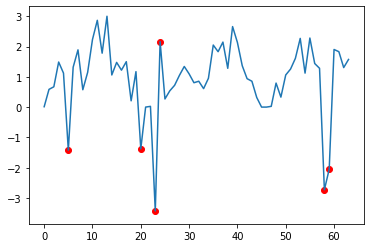

picture   1


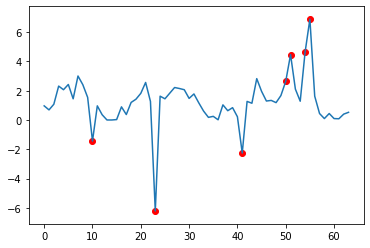

picture   2


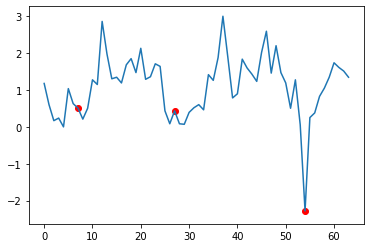

picture   3


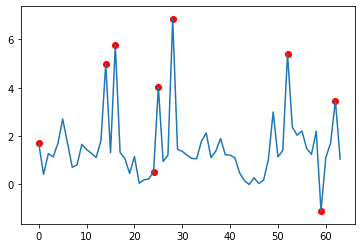

picture   4


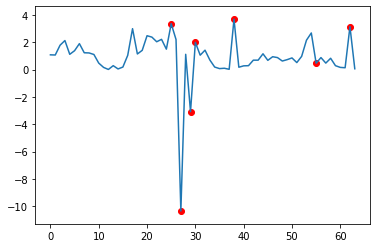

picture   5


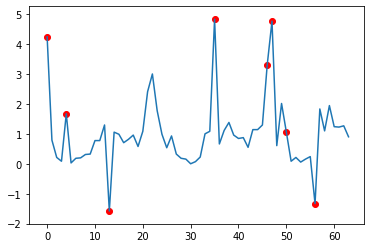

picture   6


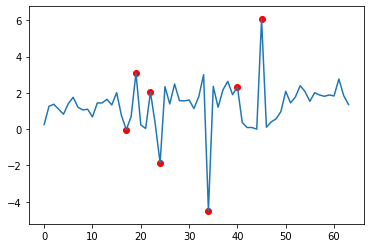

picture   7


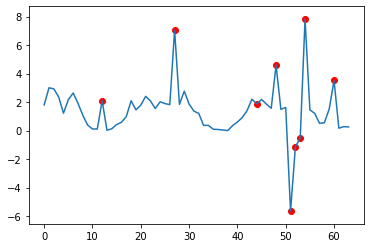

picture   8


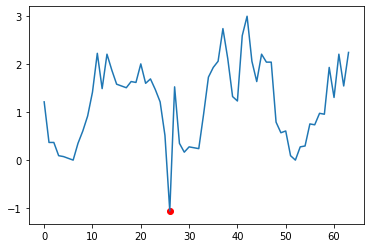

picture   9


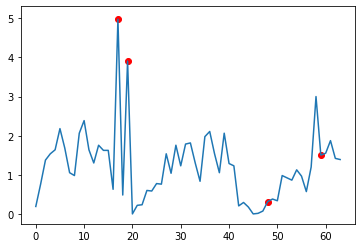

picture   10


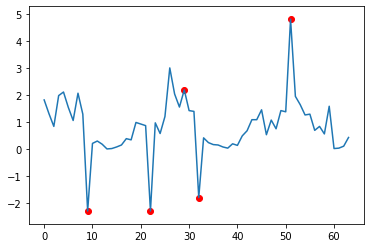

picture   11


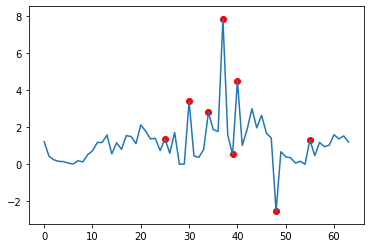

picture   12


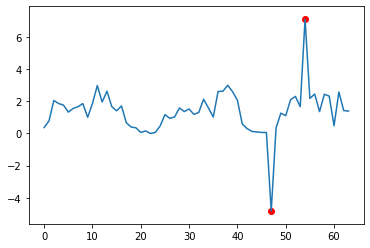

picture   13


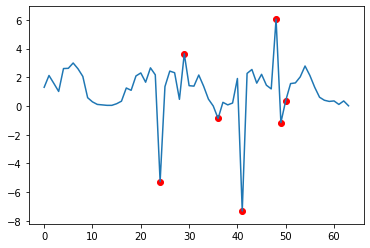

picture   14


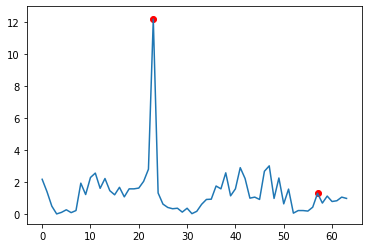

picture   15


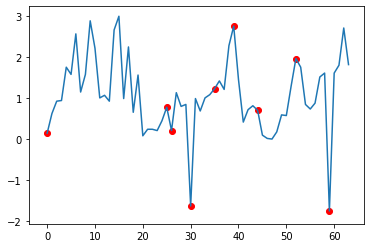

picture   16


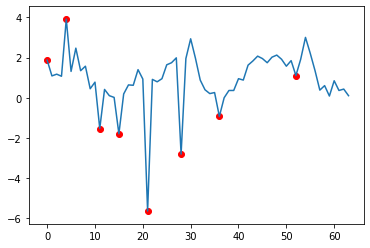

picture   17


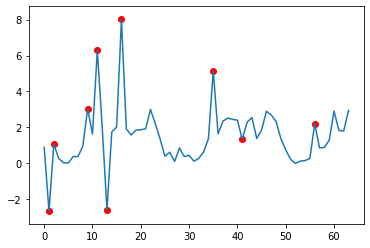

picture   18


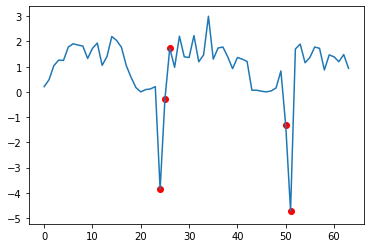

picture   19


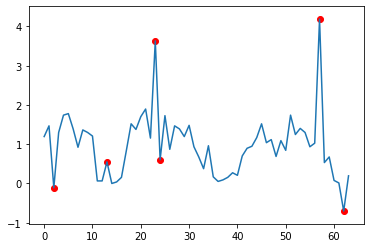

picture   20


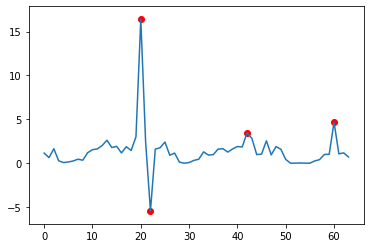

picture   21


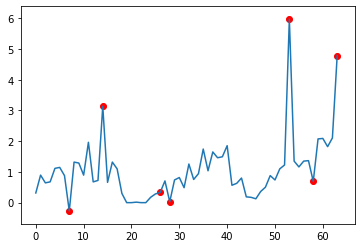

picture   22


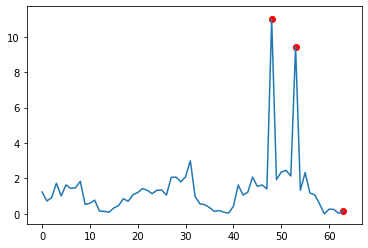

picture   23


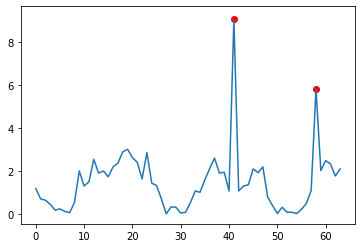

picture   24


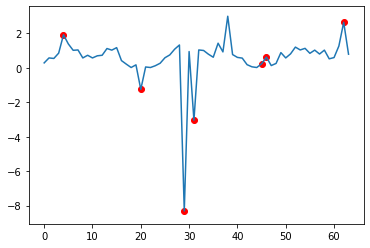

picture   25


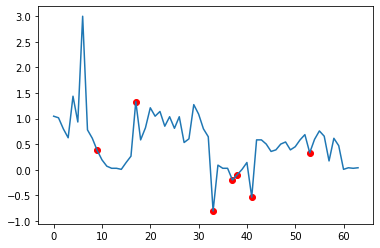

picture   26


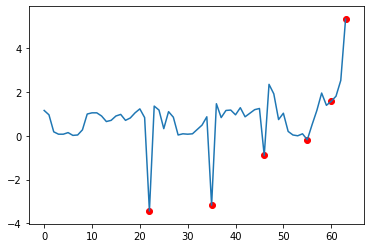

picture   27


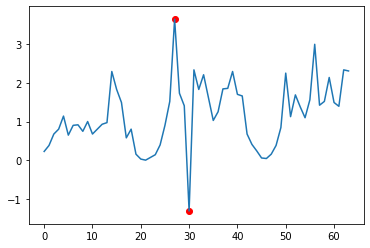

picture   28


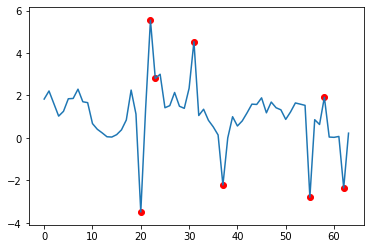

picture   29


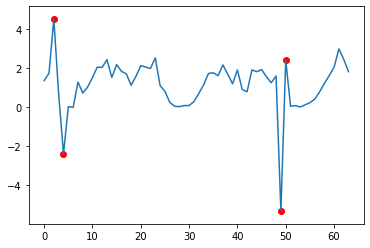

picture   30


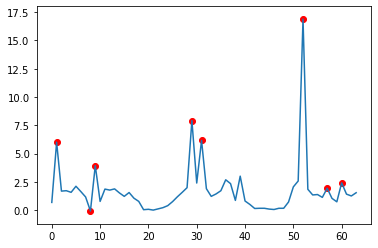

picture   31


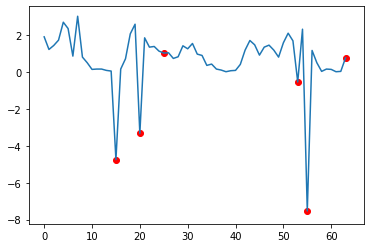

picture   32


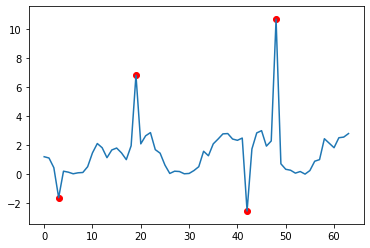

picture   33


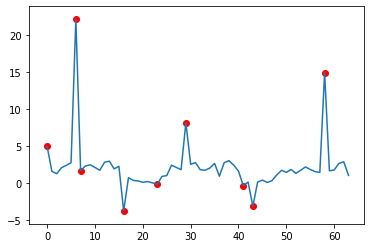

picture   34


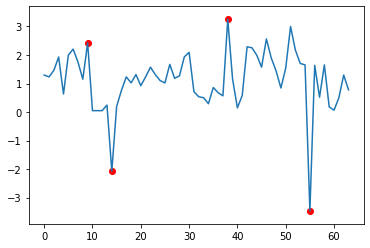

picture   35


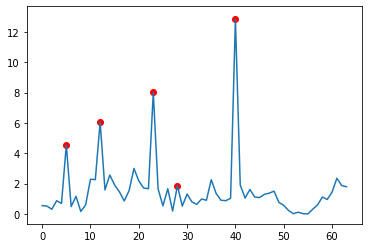

picture   36


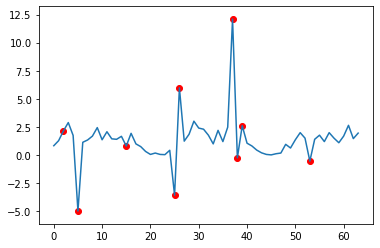

picture   37


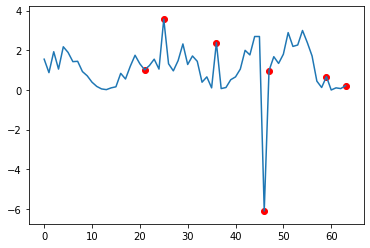

picture   38


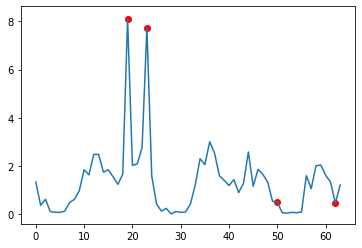

picture   39


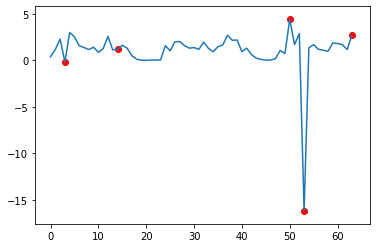

picture   40


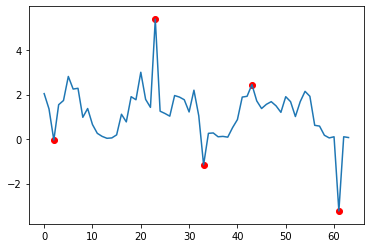

picture   41


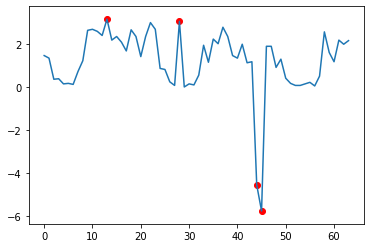

picture   42


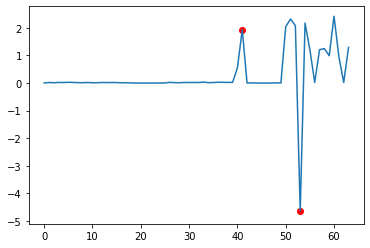

picture   43


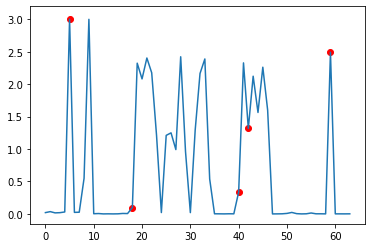

picture   44


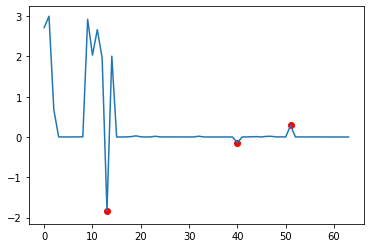

picture   45


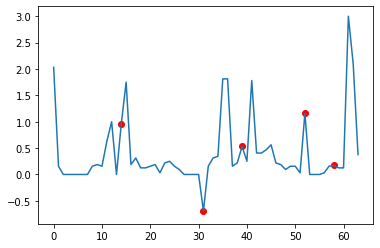

picture   46


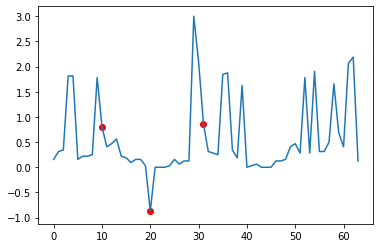

picture   47


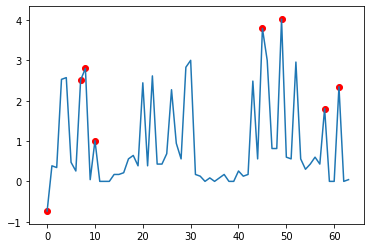

picture   48


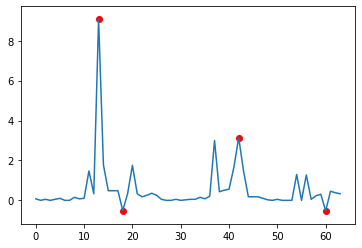

picture   49


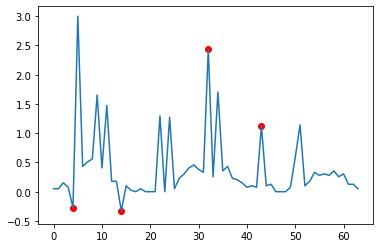

picture   50


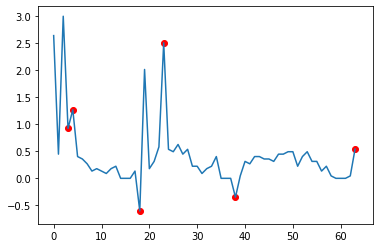

picture   51


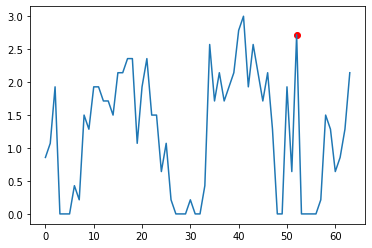

picture   52


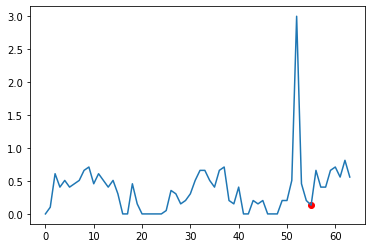

picture   53


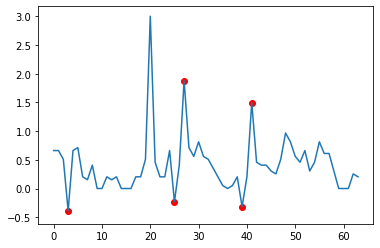

picture   54


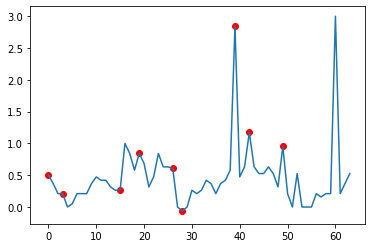

picture   55


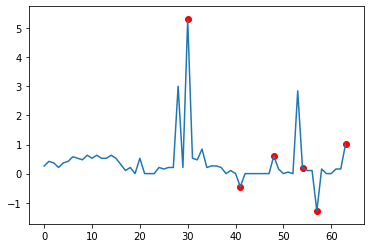

picture   56


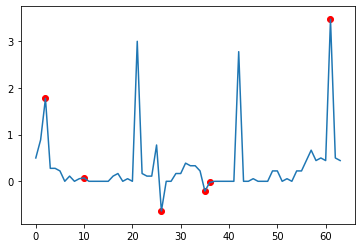

picture   57


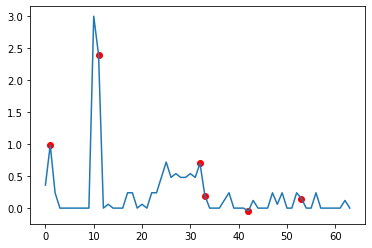

picture   58


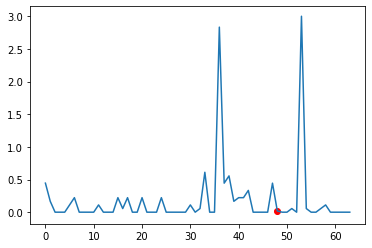

picture   59


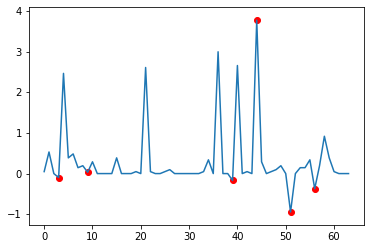

picture   60


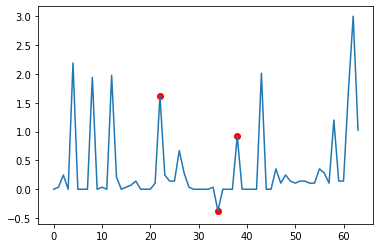

picture   61


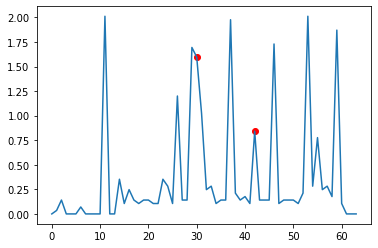

picture   62


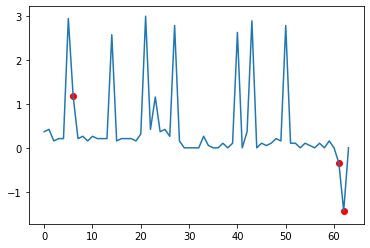

picture   63


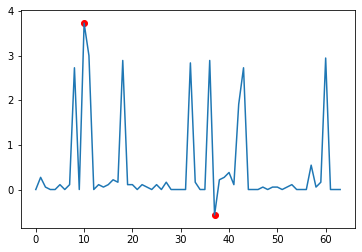

picture   64


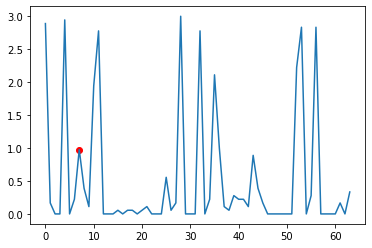

picture   65


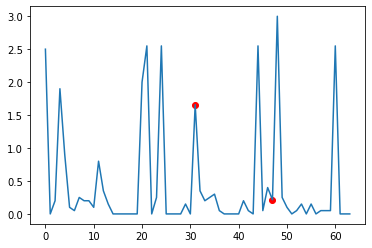

picture   66


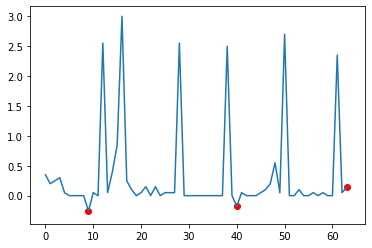

picture   67


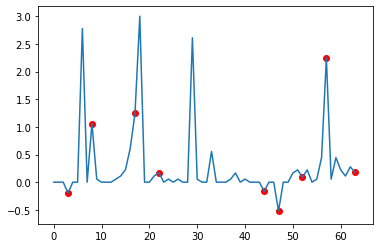

picture   68


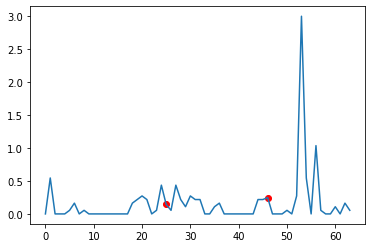

picture   69


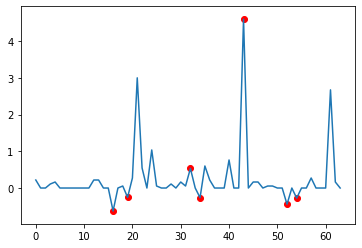

picture   70


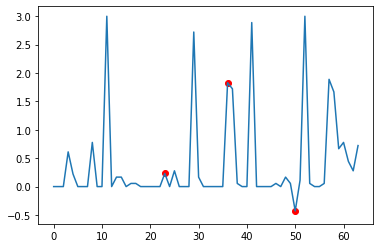

picture   71


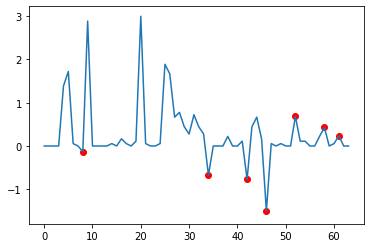

picture   72


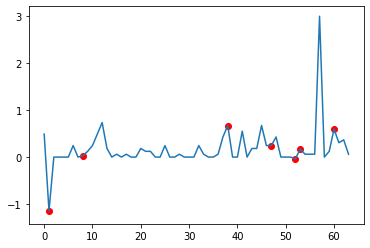

picture   73


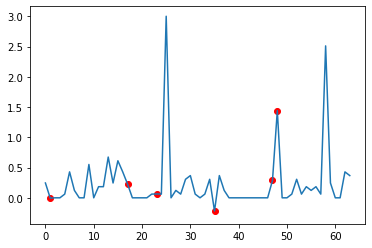

picture   74


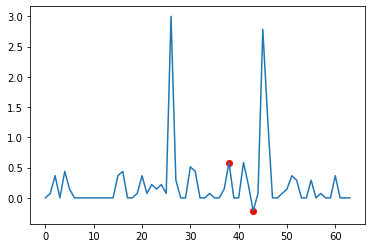

picture   75


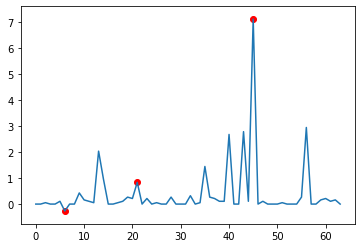

picture   76


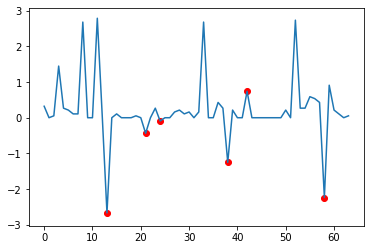

picture   77


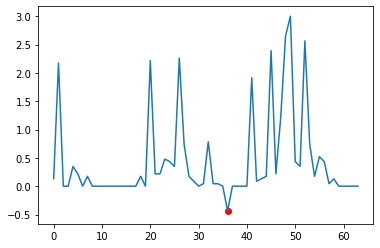

picture   78


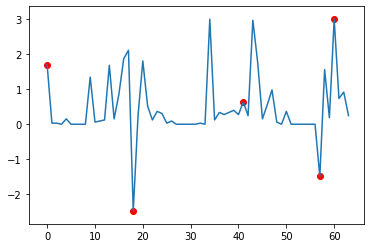

picture   79


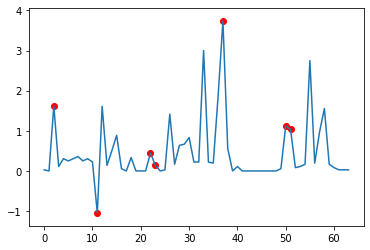

picture   80


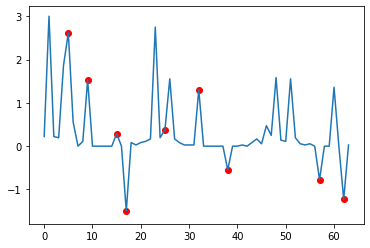

picture   81


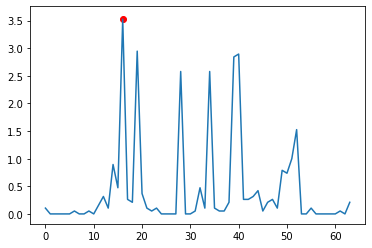

picture   82


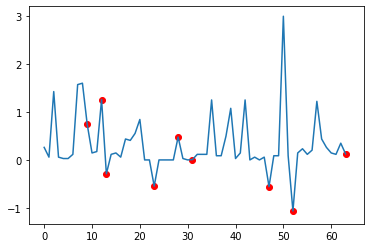

picture   83


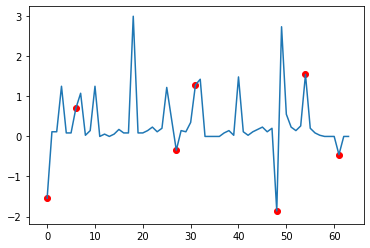

picture   84


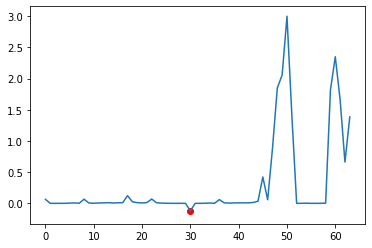

picture   85


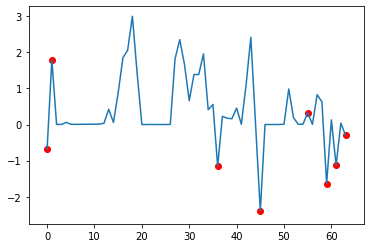

picture   86


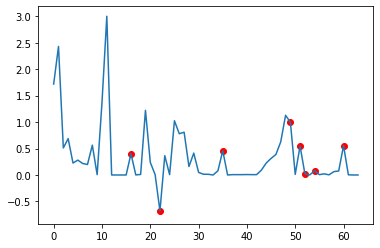

picture   87


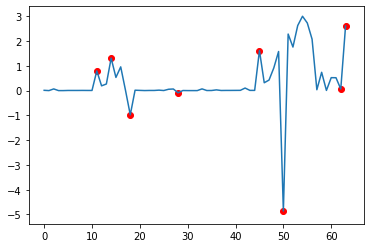

picture   88


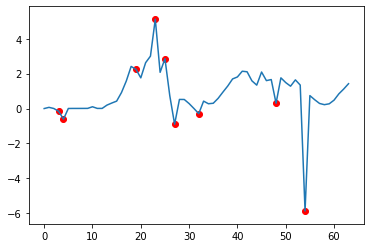

picture   89


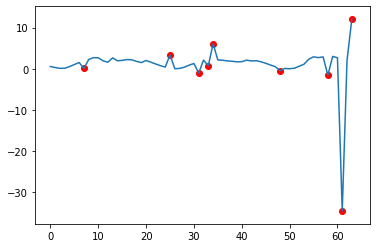

picture   90


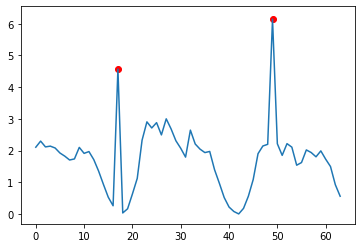

picture   91


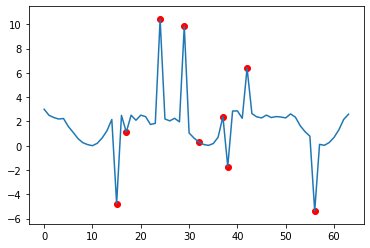

picture   92


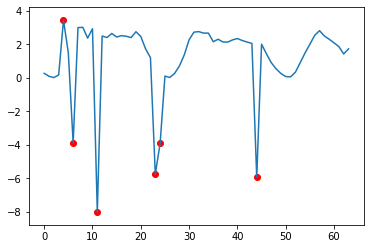

picture   93


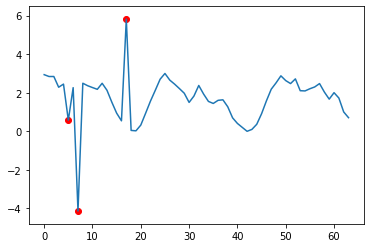

picture   94


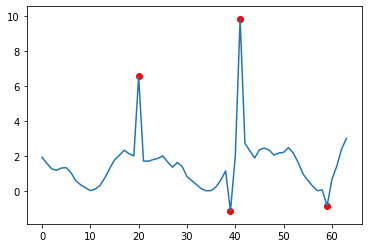

picture   95


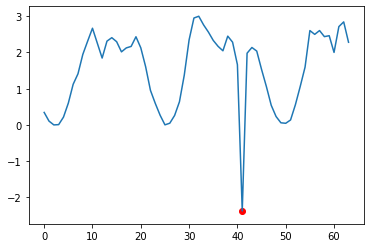

picture   96


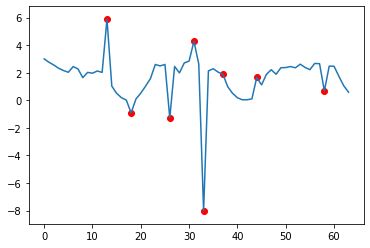

picture   97


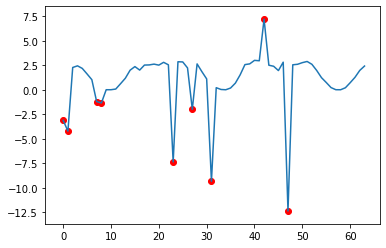

picture   98


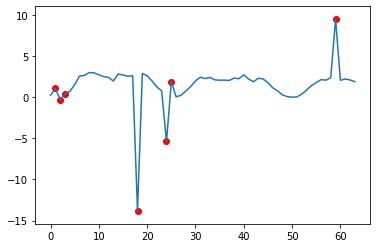

picture   99


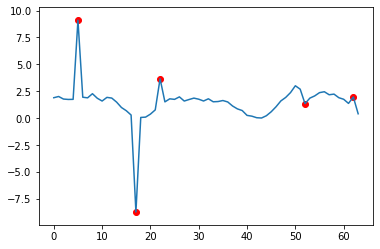

In [ ]:
for i in range(100):
    print('picture  ', i)
    plt.plot(X_train[:,0][i])
    index_changes = np.where(X_train[:,1][i] == 1)
    plt.scatter(index_changes, X_train[:,0][i][index_changes], c='red', label="change point")
    plt.show()

## 計算Spectral Residual

In [ ]:
def spectral_residual(values):
    """
    This method transform a time series into spectral residual series
    :param values: list.
        a list of float values.
    :return: mag: list.
        a list of float values as the spectral residual values
    """
    EPS = 1e-8
    trans = np.fft.fft(values) #傅立葉變換
    mag = np.sqrt(trans.real ** 2 + trans.imag ** 2) #A(f)

    maglog = [np.log(item) if abs(item) > EPS else 0 for item in mag]  #L(f)

    spectral = np.exp(maglog - average_filter(maglog, n=3)) #R(f)

    trans.real = [ireal * ispectral / imag if abs(imag) > EPS else 0
                  for ireal, ispectral, imag in zip(trans.real, spectral, mag)]
    trans.imag = [iimag * ispectral / imag if abs(imag) > EPS else 0
                  for iimag, ispectral, imag in zip(trans.imag, spectral, mag)]

    wave_r = np.fft.ifft(trans)
    mag = np.sqrt(wave_r.real ** 2 + wave_r.imag ** 2) #S(x)

    return mag, maglog

In [ ]:
class gen_set():
    def __init__(self, width, train_data):

        self.len = 0
        self.width = width
        self.train_data = train_data
        self.negrawlen = len(self.train_data)
        print('length :', len(self.train_data))
        
        self.len += self.negrawlen
        self.kpineglen = 0
        self.control = 0.

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        
        idx = index % self.negrawlen
        datas = np.array(self.train_data[idx])  # (2,128)
        data = datas[0, :].astype(np.float32)
        lbs = datas[1, :].astype(np.float32)
        
        wave, maglog = spectral_residual(data)
        waveavg = average_filter(wave)
        
        for i in range(self.width):   # 調整 Label的設置 #
            if wave[i] < 0.001 and waveavg[i] < 0.001:
                lbs[i] = 0
                continue
            ratio = wave[i] / waveavg[i]
            if ratio < 1.0 and lbs[i] == 1:
                lbs[i] = 0
            if ratio > 5.0:
                lbs[i] = 1
                
        srscore = abs(wave - waveavg) / (waveavg + 0.01)
        sortid = np.argsort(srscore)
        for idx in sortid[-2:]:
            if srscore[idx] > 5:
                lbs[idx] = 1
                
        resdata = 100 * wave
        reslb = lbs
        
        return resdata, reslb, maglog

In [ ]:
batch_size = 256
gen_data = gen_set(window, X_train)
data_list = []

for i in range(len(X_train)):
    data_list.append(gen_data.__getitem__(i))
    
X, Y = np.array(data_list)[:,0], np.array(data_list)[:,1]
train_x = X[:int(X.shape[0]*0.8)].astype(np.float32)
train_y = Y[:int(Y.shape[0]*0.8)].astype(np.float32)
vali_x = X[int(X.shape[0]*0.8):].astype(np.float32)
vali_y = Y[int(Y.shape[0]*0.8):].astype(np.float32)

print('train_x shape', train_x.shape)
print('train_y.shape', train_y.shape)
print('vali_x shape', vali_x.shape)
print('vali_y.shape', vali_y.shape)

train_buf = len(train_x)
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_dataset = train_dataset.shuffle(buffer_size=train_buf)
train_dataset = train_dataset.batch(batch_size)

vali_buf = len(vali_x)
vali_dataset = tf.data.Dataset.from_tensor_slices((vali_x, vali_y))
vali_dataset = vali_dataset.shuffle(buffer_size=vali_buf)
vali_dataset = vali_dataset.batch(batch_size)
batch_num = vali_buf % batch_size

length : 8951
train_x shape (7160, 64)
train_y.shape (7160, 64)
vali_x shape (1791, 64)
vali_y.shape (1791, 64)


## log(A(f)) -- 前100筆window

picture   0


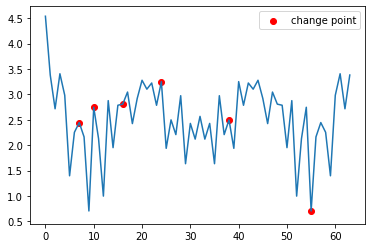

picture   1


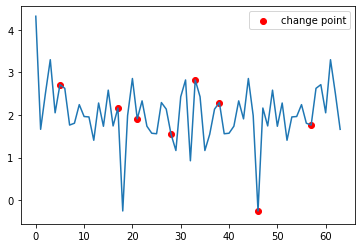

picture   2


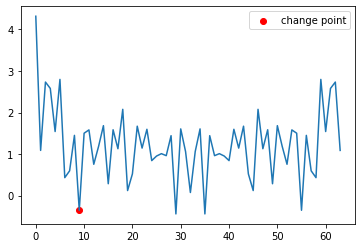

picture   3


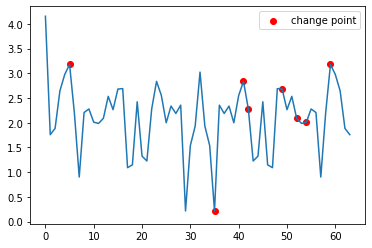

picture   4


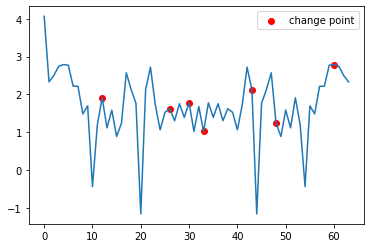

picture   5


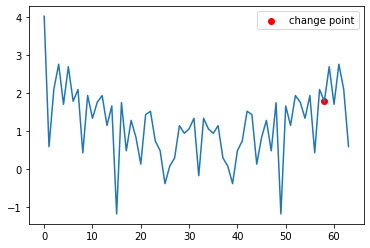

picture   6


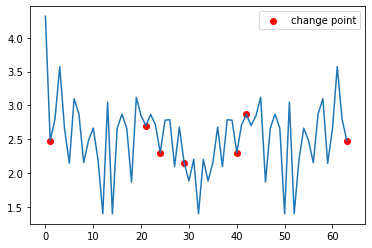

picture   7


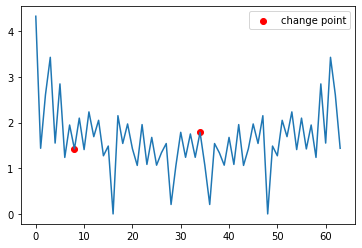

picture   8


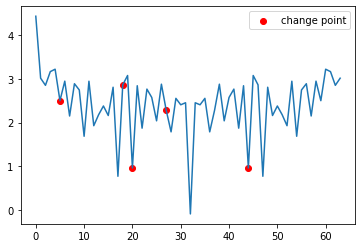

picture   9


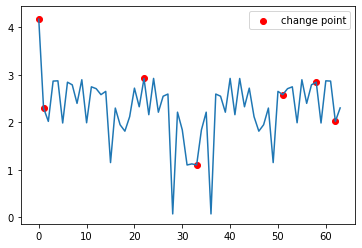

picture   10


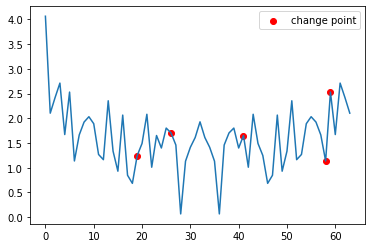

picture   11


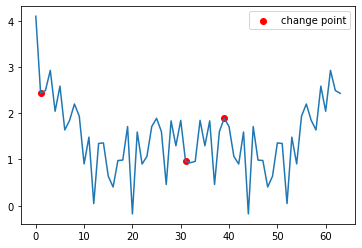

picture   12


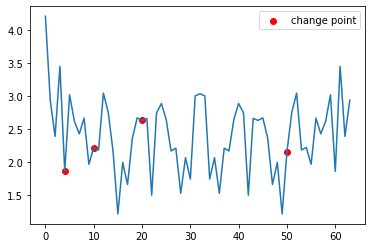

picture   13


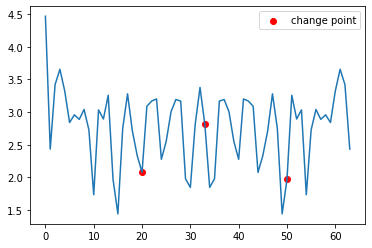

picture   14


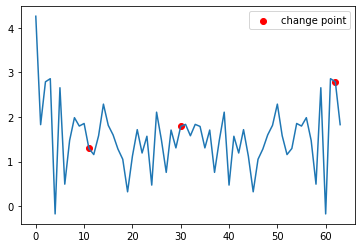

picture   15


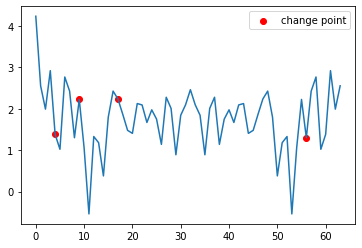

picture   16


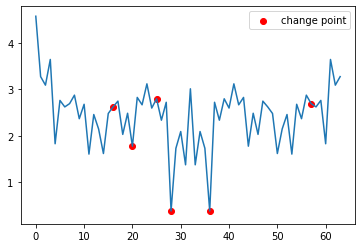

picture   17


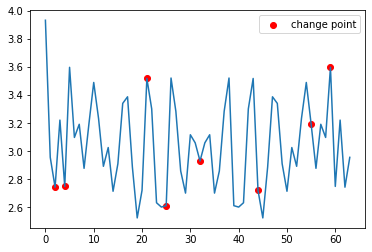

picture   18


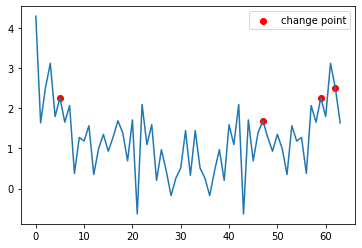

picture   19


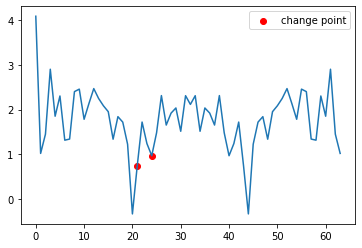

picture   20


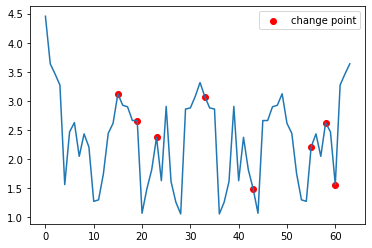

picture   21


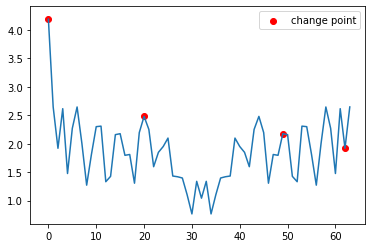

picture   22


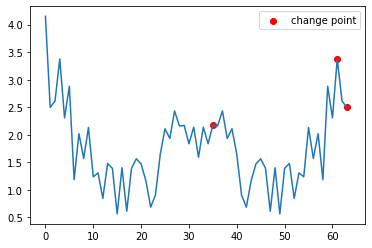

picture   23


picture   24


picture   25


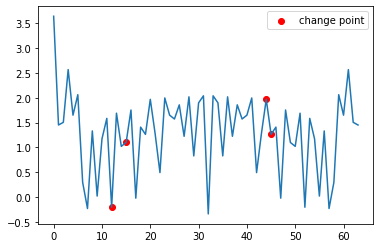

picture   26


picture   27


picture   28


picture   29


picture   30


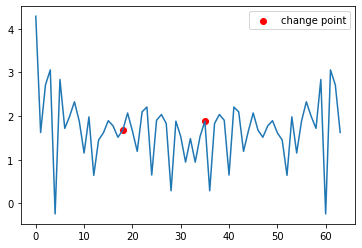

picture   31


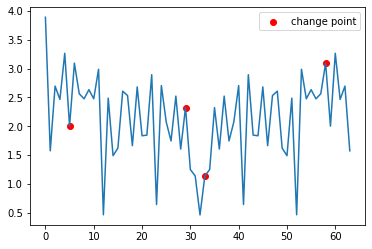

picture   32


picture   33


picture   34


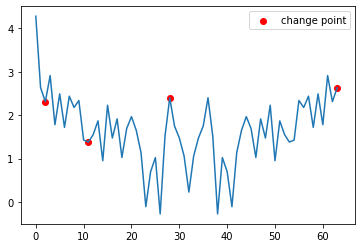

picture   35


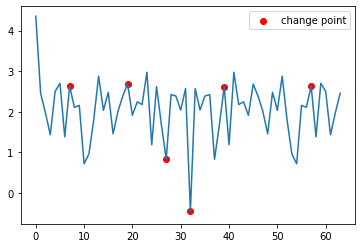

picture   36


picture   37


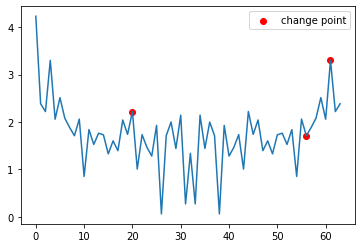

picture   38


picture   39


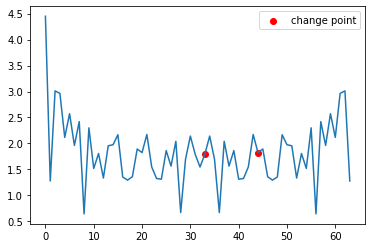

picture   40


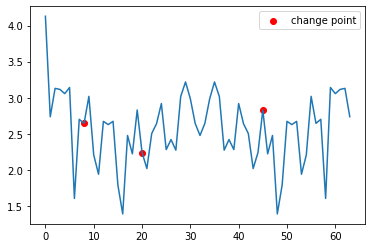

picture   41


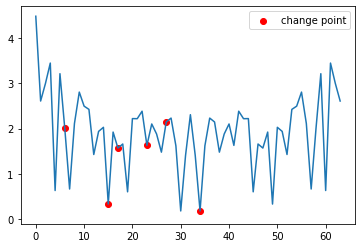

picture   42


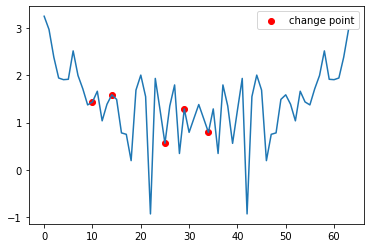

picture   43


picture   44


picture   45


picture   46


picture   47


picture   48


picture   49


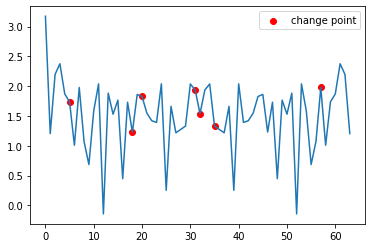

picture   50


picture   51


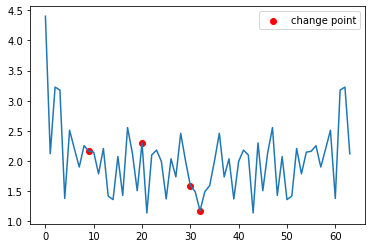

picture   52


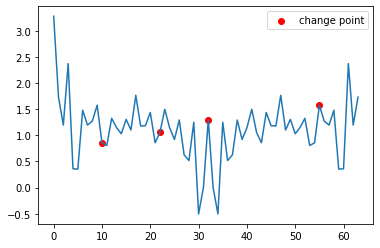

picture   53


picture   54


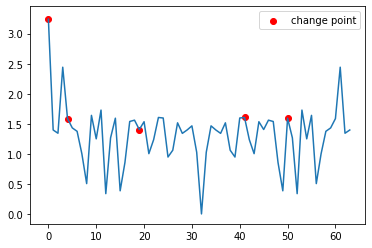

picture   55


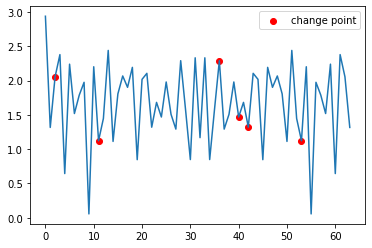

picture   56


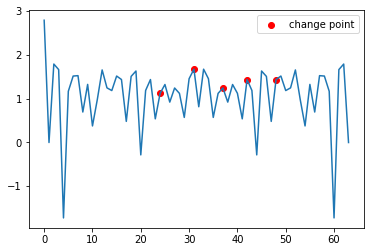

picture   57


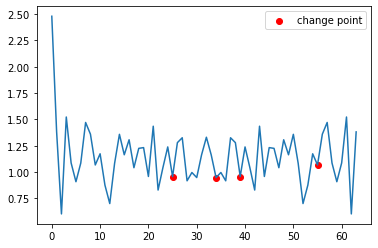

picture   58


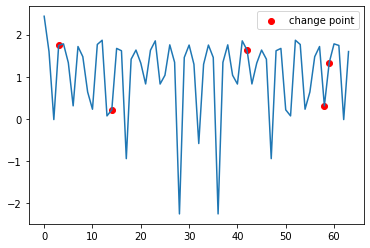

picture   59


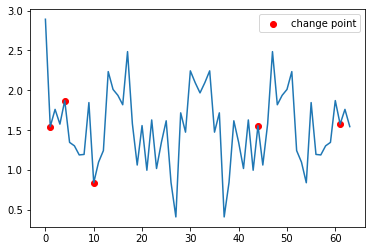

picture   60


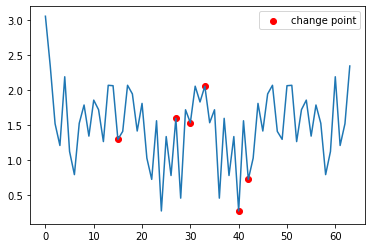

picture   61


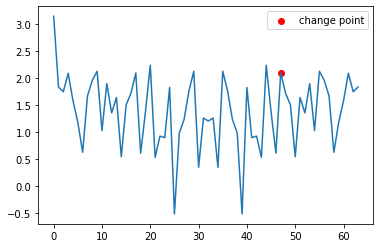

picture   62


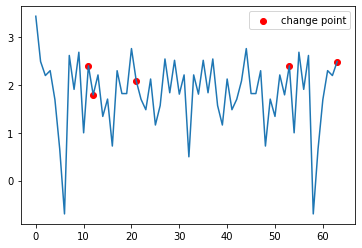

picture   63


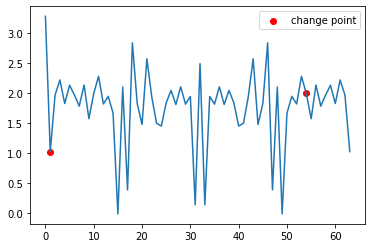

picture   64


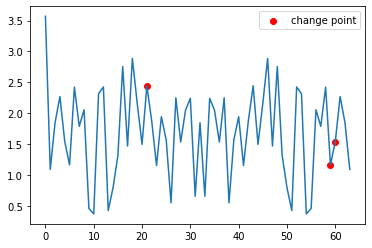

picture   65


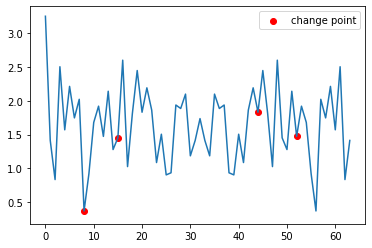

picture   66


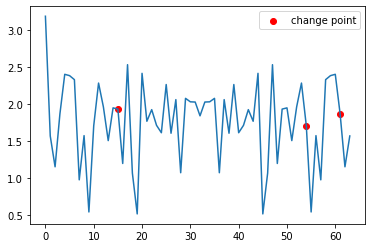

picture   67


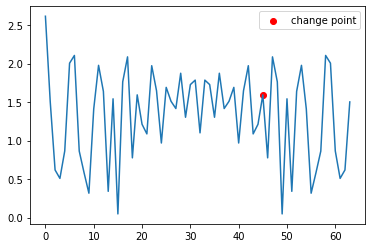

picture   68


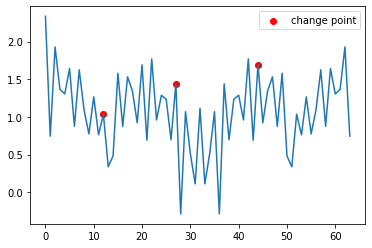

picture   69


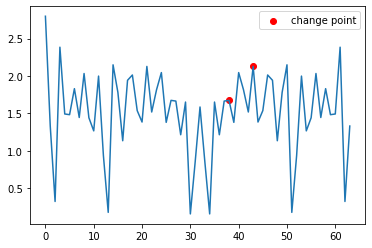

picture   70


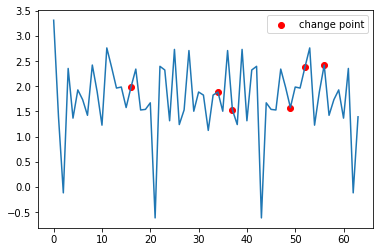

picture   71


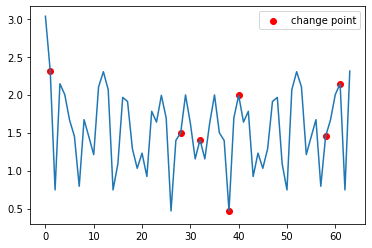

picture   72


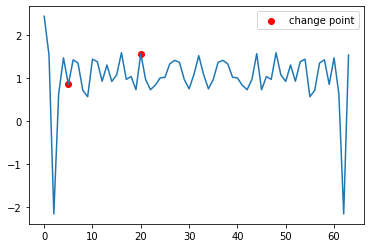

picture   73


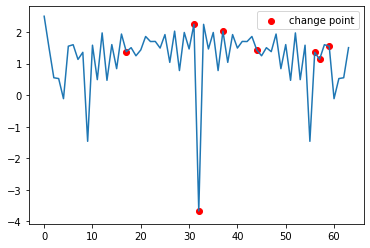

picture   74


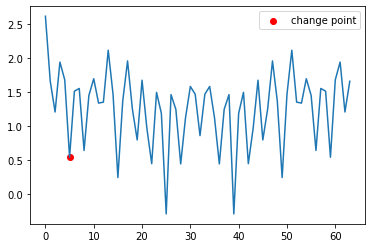

picture   75


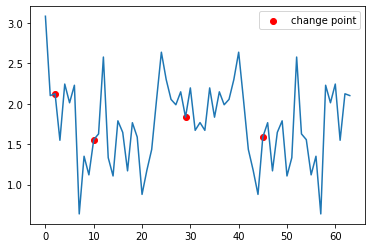

picture   76


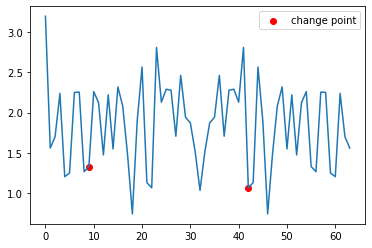

picture   77


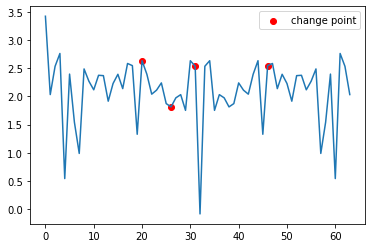

picture   78


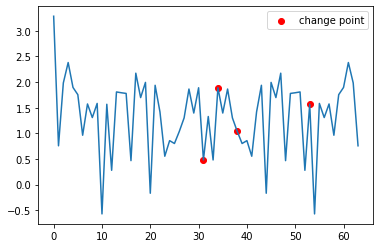

picture   79


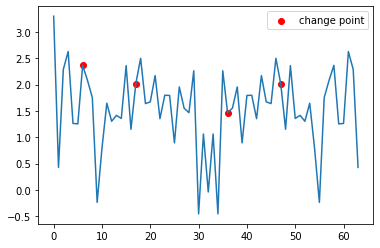

picture   80


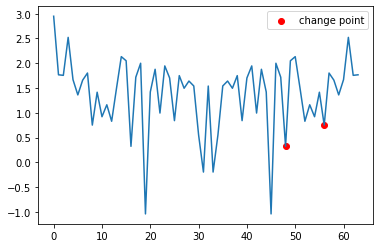

picture   81


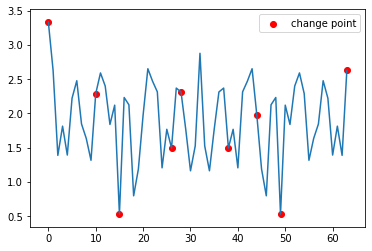

picture   82


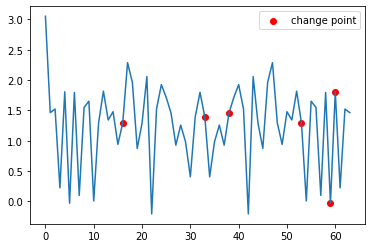

picture   83


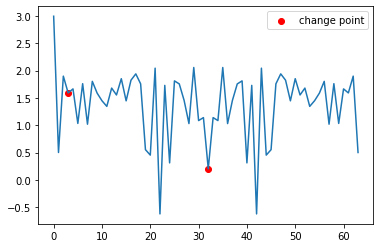

picture   84


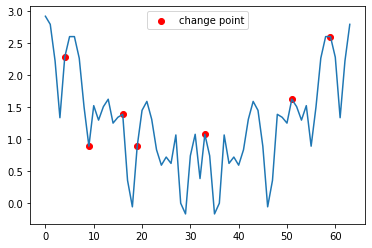

picture   85


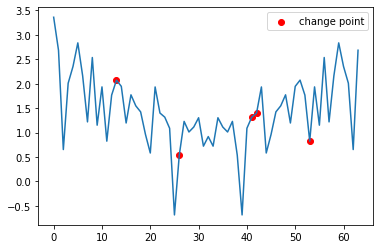

picture   86


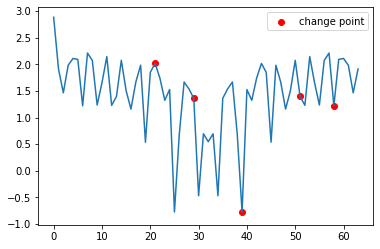

picture   87


picture   88


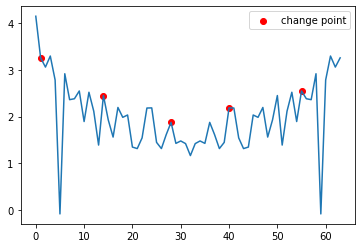

picture   89


picture   90


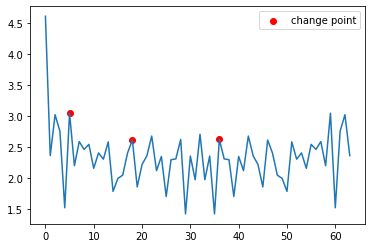

picture   91


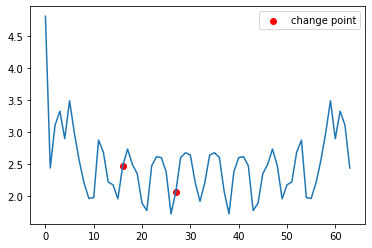

picture   92


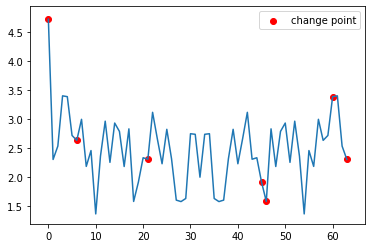

picture   93


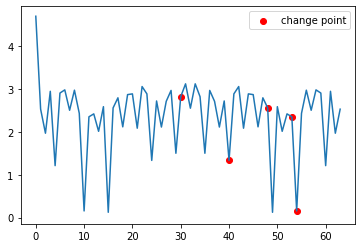

picture   94


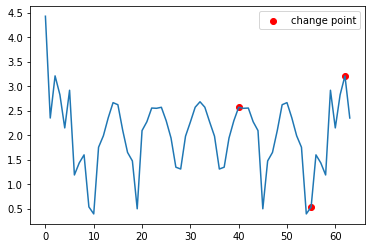

picture   95


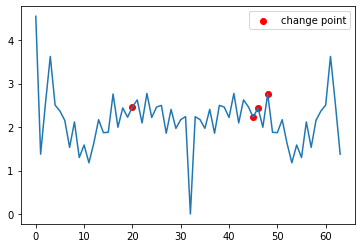

picture   96


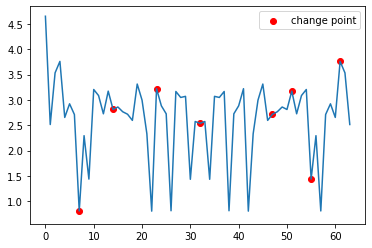

picture   97


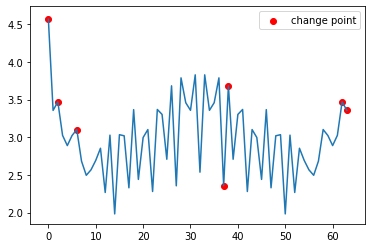

picture   98


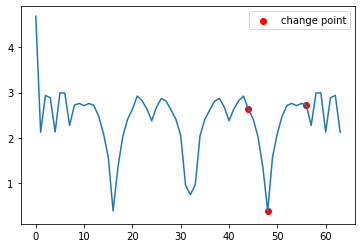

picture   99


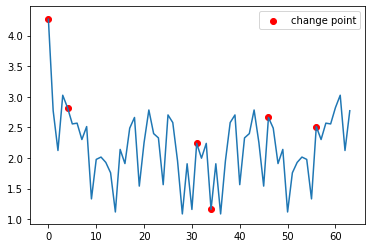

In [ ]:
for i in range(100):
    print('picture  ', i)
    plt.plot(np.array(data_list)[:,2][i])
    index_changes = np.where(train_y[i] == 1)
    plt.scatter(index_changes, np.array(data_list)[:,2][i][index_changes], c='red', label="change point")
    plt.legend()
    plt.show()

## 轉SR的Time Series與Label標記情況(前100筆window)

picture   0


picture   1


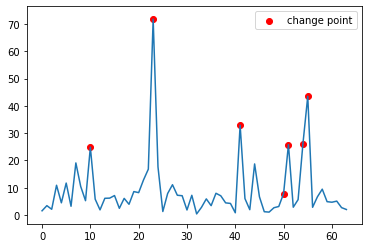

picture   2


picture   3


picture   4


picture   5


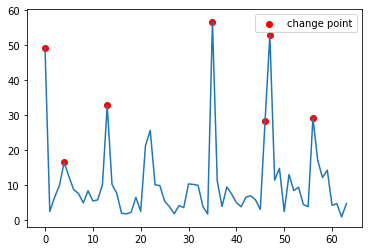

picture   6


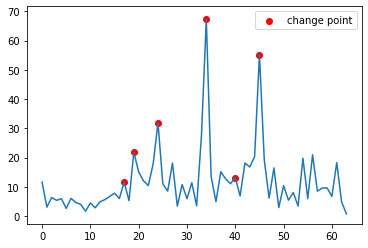

picture   7


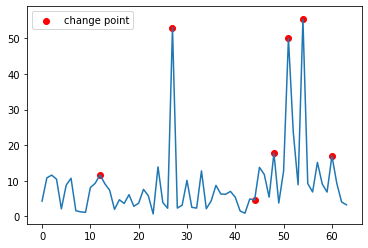

picture   8


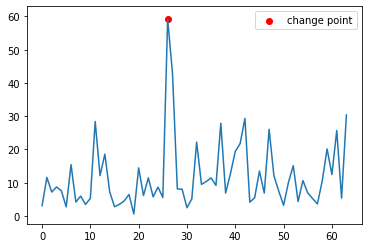

picture   9


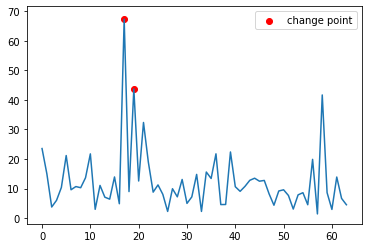

picture   10


picture   11


picture   12


picture   13


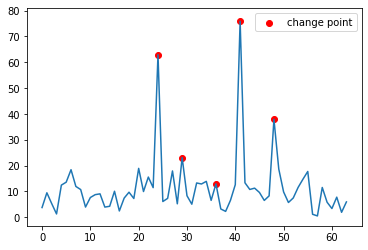

picture   14


picture   15


picture   16


picture   17


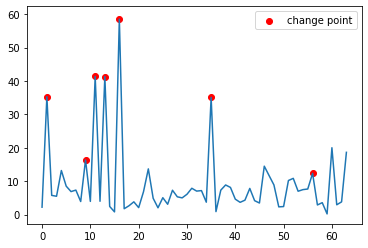

picture   18


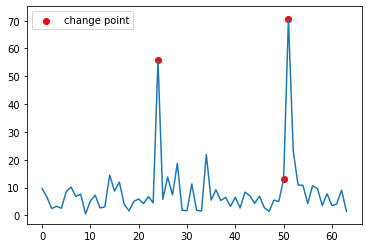

picture   19


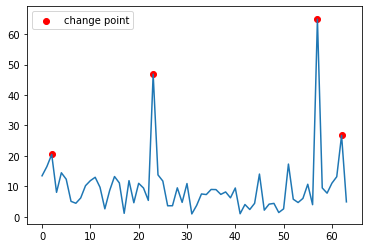

picture   20


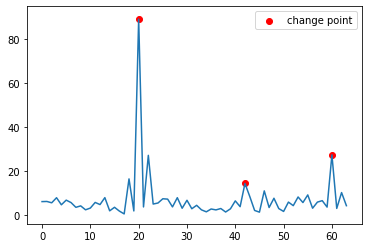

picture   21


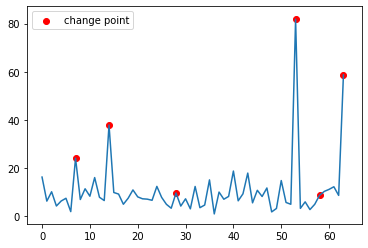

picture   22


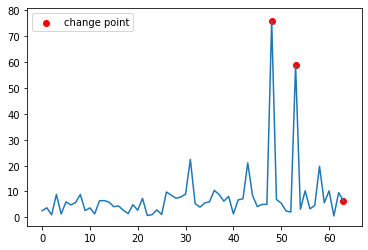

picture   23


picture   24


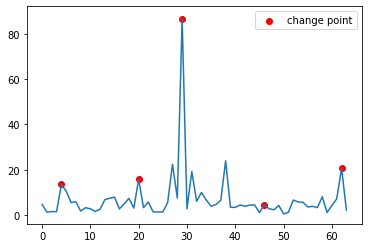

picture   25


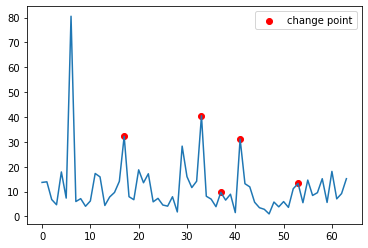

picture   26


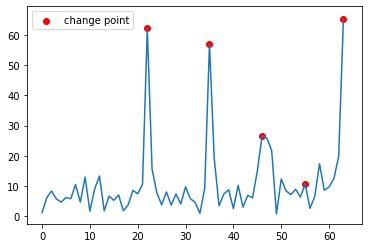

picture   27


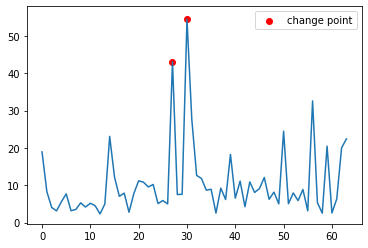

picture   28


picture   29


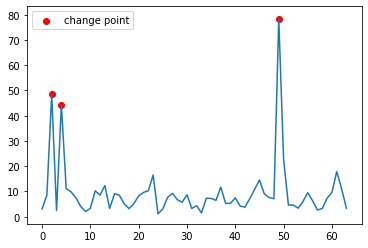

picture   30


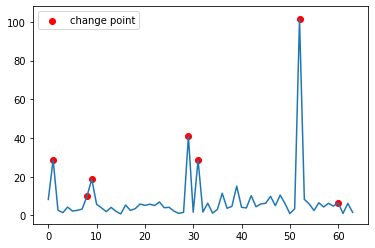

picture   31


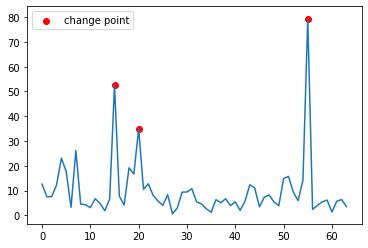

picture   32


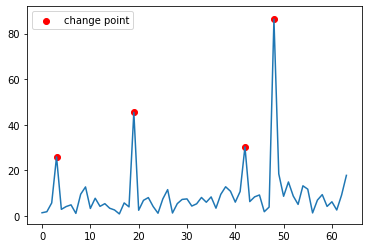

picture   33


picture   34


picture   35


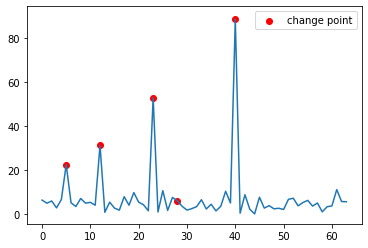

picture   36


picture   37


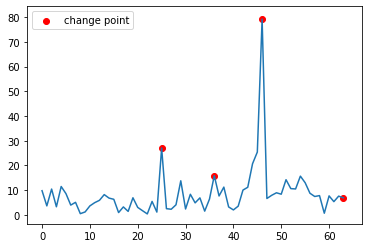

picture   38


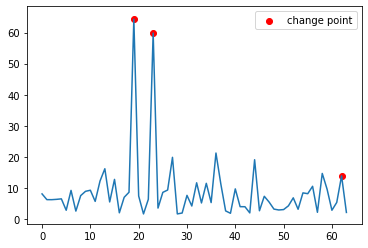

picture   39


picture   40


picture   41


picture   42


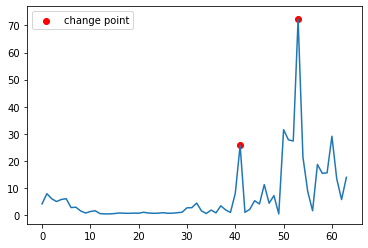

picture   43


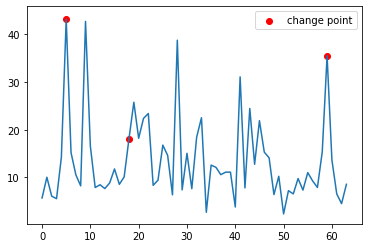

picture   44


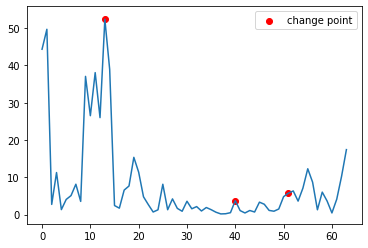

picture   45


picture   46


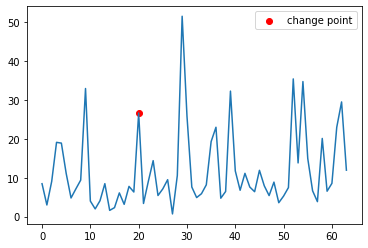

picture   47


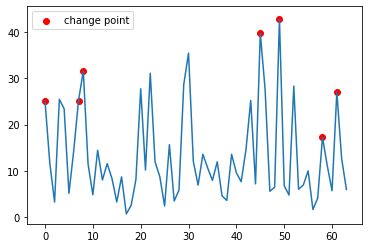

picture   48


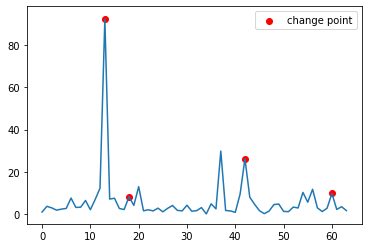

picture   49


picture   50


picture   51


picture   52


picture   53


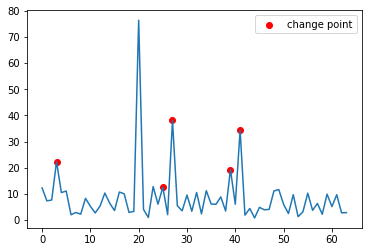

picture   54


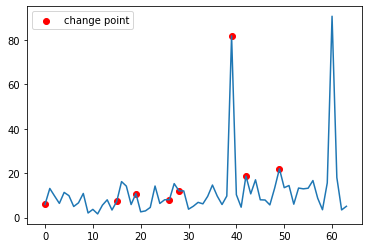

picture   55


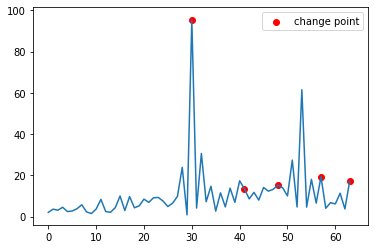

picture   56


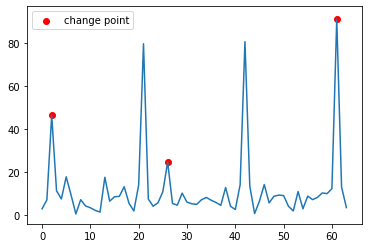

picture   57


picture   58


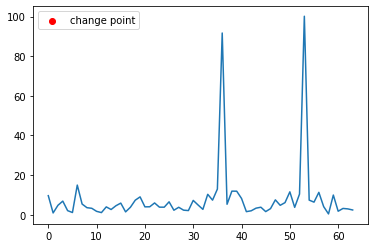

picture   59


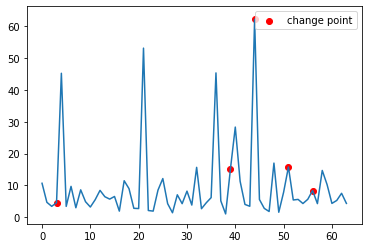

picture   60


picture   61


picture   62


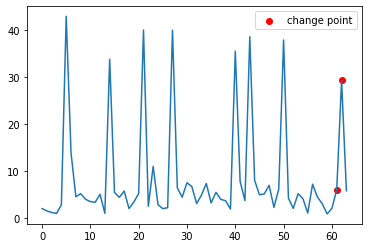

picture   63


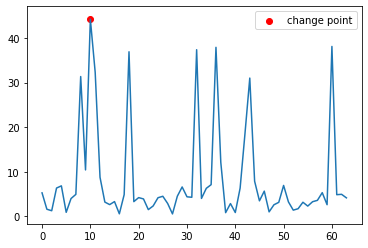

picture   64


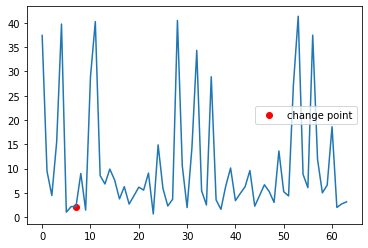

picture   65


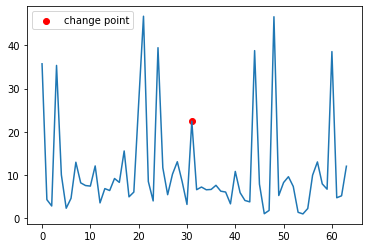

picture   66


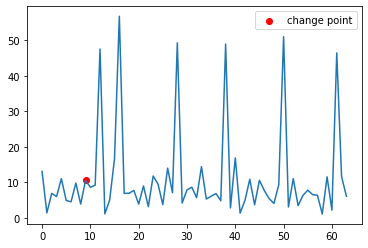

picture   67


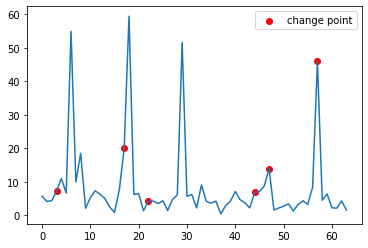

picture   68


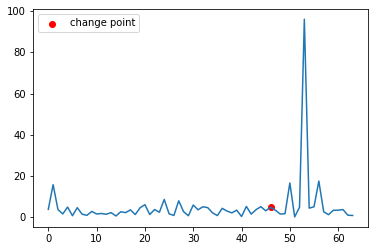

picture   69


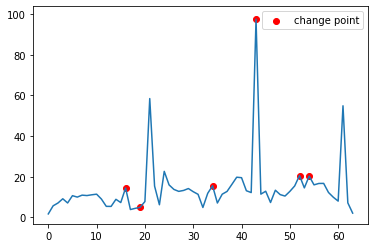

picture   70


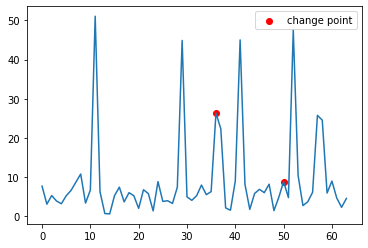

picture   71


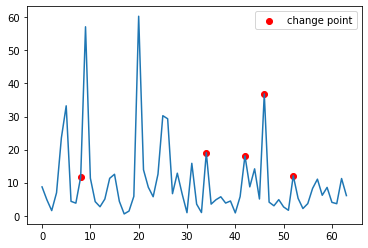

picture   72


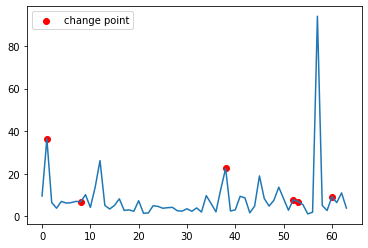

picture   73


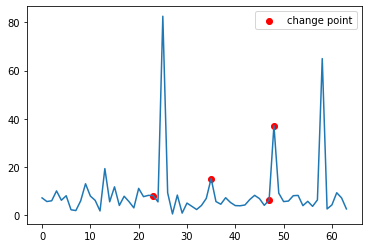

picture   74


picture   75


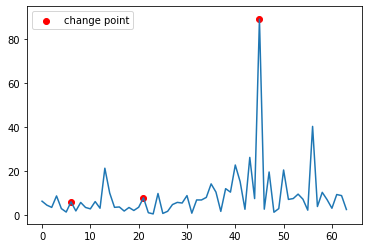

picture   76


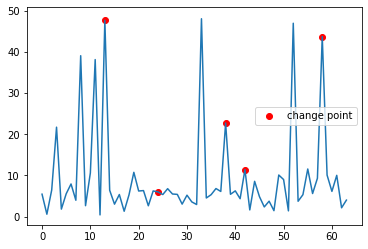

picture   77


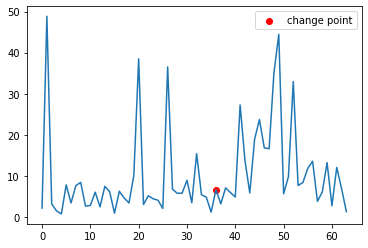

picture   78


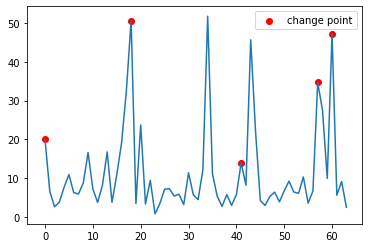

picture   79


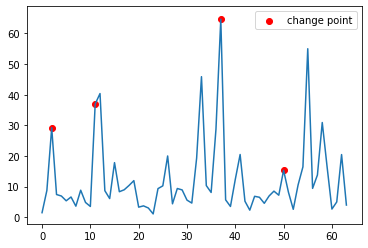

picture   80


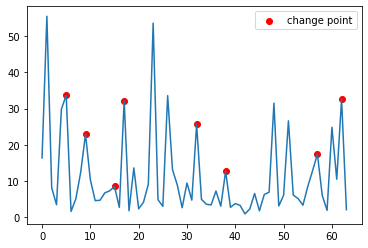

picture   81


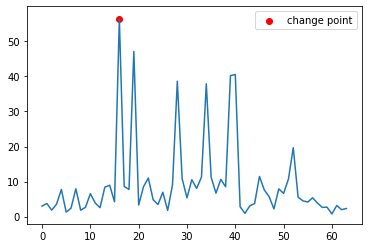

picture   82


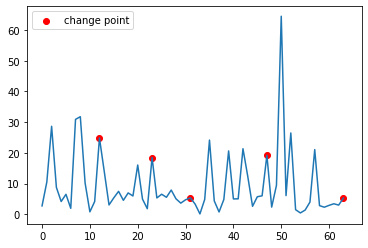

picture   83


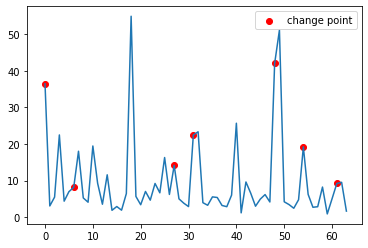

picture   84


picture   85


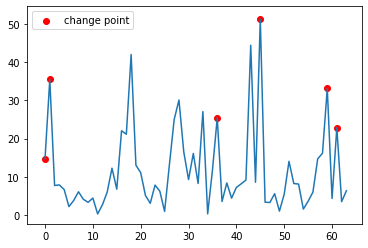

picture   86


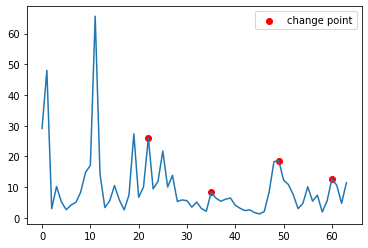

picture   87


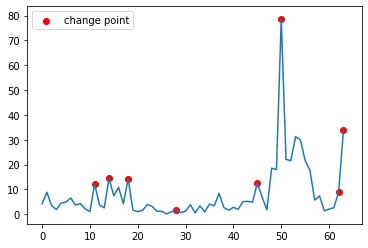

picture   88


picture   89


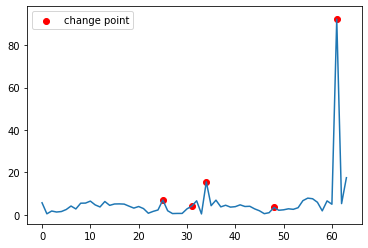

picture   90


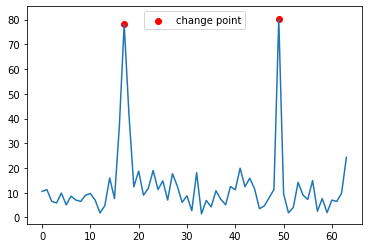

picture   91


picture   92


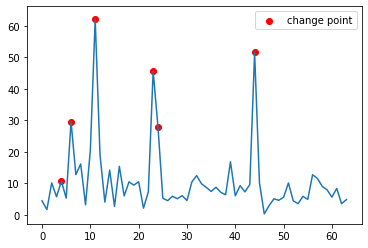

picture   93


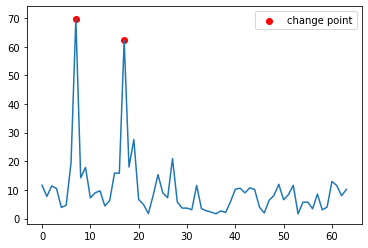

picture   94


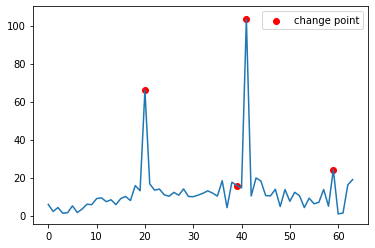

picture   95


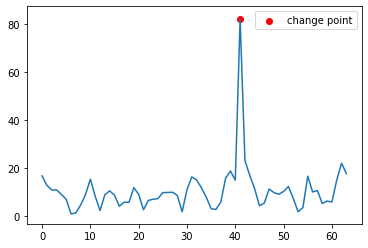

picture   96


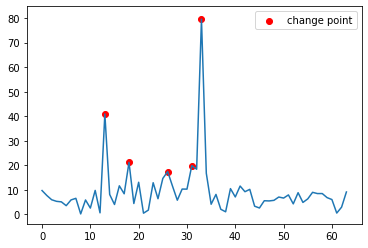

picture   97


picture   98


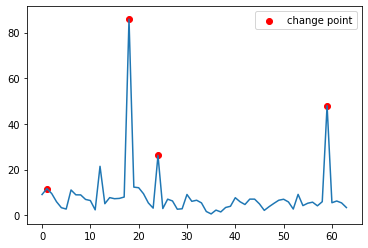

picture   99


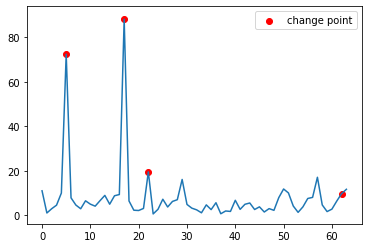

In [ ]:
for i in range(100):
    print('picture  ', i)
    plt.plot(train_x[i])
    index_changes = np.where(train_y[i] == 1)
    plt.scatter(index_changes, train_x[i][index_changes], c='red', label="change point")
    plt.legend()
    plt.show()

## 加入CNN做訓練

In [ ]:
def make_anomaly_model():
    
    inputs = tf.keras.Input(shape=(window, 1))  

    x = layers.Conv1D(window, kernel_size=1, use_bias=False, padding='valid', strides=1, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-4))(inputs)
    x = layers.ReLU()(x)
    x = layers.Conv1D(2 * window, kernel_size=1, use_bias=False, padding='valid', strides=1, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-4))(x)
    x = layers.Flatten()(x)
    x = layers.ReLU()(x)
    x = layers.Dense(4 * window, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-4))(x)
    x = layers.ReLU()(x)
    x = layers.Dense(window, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-4))(x)  # sigmoid 在 loss 加上
    model = tf.keras.Model(inputs = inputs, outputs=x)
    
    return model

anomaly_model = make_anomaly_model()
anomaly_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 1)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 64, 64)            64        
_________________________________________________________________
re_lu (ReLU)                 (None, 64, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 64, 128)           8192      
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
re_lu_1 (ReLU)               (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               209740

In [ ]:
clr = 1e-6
optimizer = tf.keras.optimizers.Adam(lr = clr)

def adjust_lr(epoch, lr):
    cur_lr = lr * (0.5 ** ((epoch + 10) // 10))
    return cur_lr

def calc(pred, true):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for pre, gt in zip(pred, true):
        if gt == 1:
            if pre == 1:
                TP += 1
            else:
                FN += 1
        if gt == 0:
            if pre == 1:
                FP += 1
            else:
                TN += 1
    return TP, FP, TN, FN

In [ ]:
def weight_binary_crossentropy(pos_weight, y_true, y_pred):
    
    loss = y_true * -tf.math.log(tf.math.sigmoid(y_pred) + 1e-8) * pos_weight + \
            (1 - y_true) * -tf.math.log(1 - tf.math.sigmoid(y_pred) + 1e-8) * (1 - pos_weight)
    
    '''loss = (1 - y_true) * y_pred + \
                    (pos_weight * y_true + (1 - pos_weight) * (1 - y_true)) * \
                    tf.math.log(1 + tf.math.exp(-tf.math.abs(y_pred)) + tf.math.maximum(-y_pred, 0))'''
    #loss = tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred, pos_weight)
    return loss


    
@tf.function
def train_model(batch_x, batch_y, pos_weight):
    with tf.GradientTape() as tape:
        tf.config.experimental_run_functions_eagerly(True)
        predict = anomaly_model(batch_x, training=True)
        output_loss = weight_binary_crossentropy(pos_weight, batch_y, predict)

    grads = tape.gradient(output_loss, anomaly_model.trainable_variables)
    grads, _ = tf.clip_by_global_norm(grads, 5.0)
    optimizer.apply_gradients(zip(grads, anomaly_model.trainable_variables))

    return output_loss, predict
    #return train_model
    
    #def wrapper(anomaly_model):

In [ ]:
def SRCNN_train(dataset, batch_num, pos_weight, threshold, clr, vali_op):
    
    checkpoint_dir = './anomaly_model'
    checkpoint = tf.train.Checkpoint(doptimizer = optimizer)

    n_epochs = 10000000000
    start = 0
    pre_loss = 0

    loss_list = []
    f1_list = []
    for epoch in range(n_epochs):
        start = time.time()
        totTP, totFP, totTN, totFN = 0, 0, 0, 0

        if epoch in [300, 500, 800]:
            clr = adjust_lr(epoch, clr)
            #print('learning rate changed!')

        epoch_loss_avg = tf.metrics.Mean()
        epoch_vali_loss_avg = tf.metrics.Mean()
        
        if vali_op:
            
            #epoch_vali_loss_avg = np.zeros((1, batch_num))
            epoch_f1_avg = np.zeros((1, batch_num))
            
            for batch_id, (batch) in enumerate(dataset):
                batch_x, batch_y = batch[0], batch[1]
                optimizer.lr = clr
                #try:
                loss_, output = train_model(tf.expand_dims(batch_x, axis=2), batch_y, pos_weight)
                '''except (UnboundLocalError, ValueError):
                    train_model = wrapper(model)
                    loss_, output = train_model(tf.expand_dims(batch_x, axis=2), batch_y, pos_weight)'''
                  
                aa = tf.reshape(output, [-1, 1])
                res = tf.where(aa > threshold, 1, 0)
                bb = tf.reshape(batch_y, [-1, 1])
                f1 = f1_score(bb, res)
                epoch_f1_avg[0][batch_id] = f1
                #epoch_vali_loss_avg[0][batch_id] = tf.math.reduce_mean(loss_)

                epoch_vali_loss_avg(loss_)
            
            f1_list.append(tf.math.reduce_mean(epoch_f1_avg))
            loss_list.append(epoch_vali_loss_avg.result())
            
            if abs(pre_loss - epoch_vali_loss_avg.result()) < 1e-8:
                epoch_vali_loss_avg.reset_states()
                break
            pre_loss = epoch_vali_loss_avg.result()
            epoch_vali_loss_avg.reset_states()

            '''f1_list.append(tf.math.reduce_mean(epoch_f1_avg))
            loss_list.append(tf.math.reduce_mean(epoch_vali_loss_avg))
            
            if abs(pre_loss - tf.math.reduce_mean(epoch_vali_loss_avg)) < 1e-8:
                break
            pre_loss = tf.math.reduce_mean(epoch_vali_loss_avg)'''
            
        else:
            for batch_id, (batch) in enumerate(dataset):
                batch_x, batch_y = batch[0], batch[1]
                optimizer.lr = clr
                
                train_model = wrapper(model)
                loss_, output = train_model(tf.expand_dims(batch_x, axis=2), batch_y, pos_weight)
                epoch_loss_avg(loss_)

            loss_list.append(epoch_loss_avg.result())
        
            if abs(pre_loss - epoch_loss_avg.result()) < 1e-10:
                break
            pre_loss = epoch_loss_avg.result()

            epoch_time = time.time() - start
            if epoch % 100 == 0:
                epoch_time = time.time() - start
                print('{:4d}: TIME: {:.2f} LOSS: {:.6f} '.format(epoch, epoch_time, epoch_loss_avg.result()))
                
            epoch_loss_avg.reset_states()
        
    
    if not vali_op:
        checkpoint.save(file_prefix = checkpoint_dir)
        plt.plot(loss_list)
        plt.show()

    return loss_list, f1_list

### 挑選超參數 weight

In [ ]:
def best_model_for_weight(weight, threshold):
    n_weight = len(weight)
    n_threshold = len(threshold)
    f1_vali = np.zeros((n_weight * n_threshold, 4)) 
    
    num = 0
    aa, bb = np.meshgrid(weight, threshold, indexing='ij')
    for i in zip(aa.flat, bb.flat): 
        
        f1_vali[num][:2] = np.array(i)
        loss_list, f1_list = SRCNN_train(vali_dataset, batch_num, i[0], i[1], 1e-4, True)
        f1_vali[num][2] = tf.math.reduce_max(f1_list)
        f1_vali[num][3] = loss_list[-1]
        print('iter: {:d} weight: {:.4} threshold: {:.4} F1 score: {:.4} loss: {:.4}'.format(num, np.array(i[0]), 
                                                                             np.array(i[1]), f1_vali[num][2], f1_vali[num][3]))
        num = num + 1
        model = tf.keras.models.clone_model(model)
        
    #看F1
    f1_vali = f1_vali[f1_vali[:,2].argsort()]
    print(f1_vali[-4:,:])
    
    #看loss
    #f1_vali = f1_vali[f1_vali[:,3].argsort()] 
    #print(f1_vali[:4,:])
    
    return f1_vali[-4:,:]   #f1_vali[-4:,:]  #f1_vali[:4,:]

In [ ]:
#weight = np.linspace(0.1, 0.99, num=6)
weight = np.append((10. ** ((-1)*np.arange(10))), 0)
threshold = np.linspace(0.2, 0.9, num=3)
best = best_model_for_weight(weight, threshold)

UnboundLocalError: local variable 'train_model' referenced before assignment

### 正式訓練

Select Weight: 0.0
Select Threshold: 0.9
--------start train----------
   0: TIME: 5.13 LOSS: 13.967332 
 100: TIME: 4.86 LOSS: 0.077291 
 200: TIME: 5.05 LOSS: 0.000202 
 300: TIME: 5.08 LOSS: 0.000103 


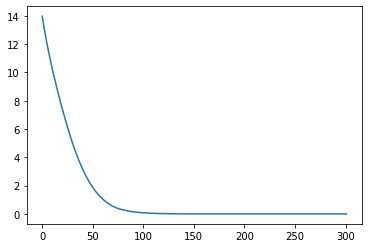

In [ ]:
best_weight = best[-1,0]  # [-1,0] [0,0]
best_threshold = best[-1,1]
print('Select Weight:', best_weight)
print('Select Threshold:', best_threshold)

print('--------start train----------')
trainloss, _ = SRCNN_train(train_dataset, None, best_weight, best_threshold, clr, False, anomaly_model)

In [ ]:
anomaly_model.save('anomaly_model_yahoo_test3_bestw.h5')

In [ ]:
def distance(data, label):
    
    score = anomaly_model(tf.expand_dims(data, axis=2), training=False)
    score = tf.math.sigmoid(score)
    label_num = 1

    plt.title(' test data')
    plt.hist(score[label==label_num], rwidth=0.3, color='r' ,bins = 100,label = 'anomaly')
    plt.hist(score[label!=label_num], rwidth = 0.3, color = 'b',label = 'normal', bins = 100)
    plt.legend()
    plt.show()
    plt.title(' test data anomaly')
    plt.hist(score[label==label_num], rwidth=0.3, color='r' ,bins = 100,label = 'anomaly')
    plt.legend()
    plt.show()
    plt.title(' test data normal')
    plt.hist(score[label!=label_num], rwidth = 0.3, color = 'b',label = 'normal', bins = 100)
    plt.legend()
    plt.show()

    
    return score

In [ ]:
distance(train_x, train_y)

<tf.Tensor: id=2415344, shape=(7160, 64), dtype=float32, numpy=
array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [5.9604645e-08, 0.0000000e+00, 0.0000000e+00, ..., 2.9802322e-08,
        2.9802322e-08, 0.0000000e+00],
       [1.2516975e-06, 9.5367432e-07, 1.2516975e-06, ..., 1.0132790e-06,
        1.9669533e-06, 2.9802322e-07]], dtype=float32)>

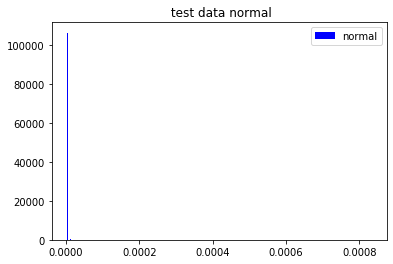

<tf.Tensor: id=2415487, shape=(1791, 64), dtype=float32, numpy=
array([[0.0000000e+00, 0.0000000e+00, 5.9604645e-08, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.1920929e-07, 1.1920929e-07, 1.4901161e-07, ..., 0.0000000e+00,
        2.9802322e-08, 5.9604645e-08]], dtype=float32)>

In [ ]:
distance(vali_x, vali_y)

## Evaluation

In [ ]:
def predict_next(values):
    """
    Predicts the next value by sum up the slope of the last value with previous values.
    Mathematically, g = 1/m * sum_{i=1}^{m} g(x_n, x_{n-i}), x_{n+1} = x_{n-m+1} + g * m,
    where g(x_i,x_j) = (x_i - x_j) / (i - j)
    :param values: list.
        a list of float numbers.
    :return : float.
        the predicted next value.
    """

    if len(values) <= 1:
        raise ValueError(f'data should contain at least 2 numbers')
    
    v_last = values[-1]
    n = len(values)

    slopes = [(v_last - v) / (n - 1 - i) for i, v in enumerate(values[:-1])]

    return values[1] + sum(slopes)

def extend_series(values, extend_num=5, look_ahead=5):
    """
    extend the array data by the predicted next value
    :param values: list.
        a list of float numbers.
    :param extend_num: int, default 5.
        number of values added to the back of data.
    :param look_ahead: int, default 5.
        number of previous values used in prediction.
    :return: list.
        The result array.
    """

    if look_ahead < 1:
        raise ValueError('look_ahead must be at least 1')
    values = list(values)
    extension = [predict_next(values[-look_ahead - 2:-1])] * extend_num
    return values + extension

In [ ]:
def get_range_proba(predict, label, delay=7):
    predict = np.array(predict)
    label = np.array(label)

    splits = np.where(label[1:] != label[:-1])[0] + 1
    is_anomaly = label[0] == 1
    new_predict = np.array(predict)
    pos = 0

    for sp in splits:
        if is_anomaly:
            if 1 in predict[pos:min(pos + delay + 1, sp)]:
                new_predict[pos: sp] = 1
            else:
                new_predict[pos: sp] = 0
        is_anomaly = not is_anomaly
        pos = sp
    sp = len(label)

    if is_anomaly:
        if 1 in predict[pos: min(pos + delay + 1, sp)]:
            new_predict[pos: sp] = 1
        else:
            new_predict[pos: sp] = 0

    return new_predict


def reconstruct_label(timestamp, label):
    
    timestamp = np.asarray(timestamp)
    index = np.argsort(timestamp)

    timestamp_sorted = np.asarray(timestamp[index])
    interval = np.min(np.diff(timestamp_sorted))

    label = np.asarray(label, np.int64)
    label = np.asarray(label[index])

    idx = (timestamp_sorted - timestamp_sorted[0]) // interval

    new_label = np.zeros(shape=((timestamp_sorted[-1] - timestamp_sorted[0]) // interval + 1,), dtype=np.int)
    new_label[idx] = label

    return new_label


def reconstruct_series(timestamp, label, predict, delay=7):
    
    label = reconstruct_label(timestamp, label)
    predict = reconstruct_label(timestamp, predict)
    predict = get_range_proba(predict, label, delay)  # 考慮延遲異常點
    return list(label), list(predict)

In [ ]:
def evaluate_for_all_series(lst_timestamp_label_predict, delay=7, prt=True):
    labels, predicts = [], []
    for timestamp, label, predict in lst_timestamp_label_predict:
        if timestamp == []:
            continue
        lbl, pdt = reconstruct_series(timestamp, label, predict, delay)
        labels += lbl
        predicts += pdt

    f1 = f1_score(labels, predicts)
    pre = precision_score(labels, predicts)
    rec = recall_score(labels, predicts)
    TP, FP, TN, FN = calc(predicts, labels)
    if prt:
        print('precision', pre)
        print('recall', rec)
        print('f1', f1)
        print('TP: {:} FP: {:} TN: {:} FN: {:}'.format(TP, FP, TN, FN))
        print('-------------------------------')
    return f1, pre, rec, TP, FP, TN, FN

In [ ]:
def window_test(timestamp, value, back_k=0, backaddnum=5, step=32):

    win_size = window
    length = len(timestamp)
    if back_k <= 5:
        back = back_k
    else:
        back = 5
        
    mag_list = []
    for pt in range(int(win_size - backaddnum + back + step), int(length - back), step):
        head = max(0, pt - (win_size - backaddnum))
        tail = min(length, pt)
        wave = np.array(extend_series(value[head:tail + back])) # backaddnum = 增加K個估計點 K=5
        mag, _ = spectral_residual(wave)
        mag_list.append(mag)
    
    return mag_list

In [ ]:
def sr_cnn_eval(SR_output, timestamp, value, label, ms_optioin, threshold=0.95, back_k=0, backaddnum=5, step=32):

    def modelwork(x):
        x = 100 * np.array(x)
        x = np.expand_dims(x, axis=2)
        
        anomaly_model = tf.keras.models.load_model('anomaly_model_yahoo_test3_bestw.h5', compile=False)
        output = tf.math.sigmoid(anomaly_model(x))
        aa = np.reshape(output, [1, -1])
        res = np.where(aa > threshold, 1, 0)
        aa = np.reshape(aa, [-1, win_size])
        res = np.reshape(res, [-1, win_size])
        
        return res, aa

    win_size = window
    length = len(timestamp)
    if back_k <= 5:
        back = back_k
    else:
        back = 5
    detres = np.zeros((win_size - backaddnum,))
    scores = np.zeros((win_size - backaddnum,))

    modeloutput, rawout = modelwork(SR_output)
    num = 0
    for pt in range(int(win_size - backaddnum + back + step), int(length - back), step):
        head = max(0, pt - (win_size - backaddnum))
        tail = min(length, pt)
        modeloutput_ = modeloutput[num,:]
        rawout_ = rawout[num,:]
        num += 1
        
        for ipt in range(pt - step - back, pt - back):
            detres = np.append(detres, modeloutput_[ipt - head])
            scores = np.append(scores, rawout_[ipt - head].item())
    
    detres = np.append(detres, np.zeros((length - len(detres),)))   # detres : predict結果 [0,1]顯示
    scores = np.append(scores, np.zeros((length - len(scores),)))   # scores : predict結果 未切割[0,1]顯示
    
    if ms_optioin == 'anomaly':
        last = -1
        
        interval = min([timestamp[i] - timestamp[i - 1] for i in range(1, len(timestamp))]) # 計算兩兩間隔時間 取min
        for i in range(1, len(timestamp)):
            if timestamp[i] - timestamp[i - 1] > interval:
                if last >= 0 and i - last < 1000:
                    detres[i] = 1
                    scores[i] = 1
            if detres[i] == 1:
                last = i
    
    return list(timestamp), label[:], detres[:], scores[:]

In [ ]:
def get_score(thres, option):
    total_time = 0
    results = []
    savedscore = []
    
    df_test = pd.read_csv('/PAPER/SRCNN/yahoo/yahoo_total_data.csv')
    half_len = int(df_test.shape[0]/2)
    in_timestamp, in_value, in_label = df_test['timestamp'][half_len:], df_test['value'][half_len:], df_test['is_anomaly'][half_len:]
    
    
    length = len(in_timestamp)
    
    time_start = time.time()
    SR_output = window_test(np.array(in_timestamp), in_value)
    #print(np.array(SR_output).shape)
    timestamp, label, pre, scores = sr_cnn_eval(SR_output, np.array(in_timestamp), in_value, in_label, option, thres)
    
    time_end = time.time()
    total_time = time_end - time_start
    results.append([timestamp, label, pre])
    savedscore.append([label, scores, timestamp])
    
    return total_time, results, savedscore

In [ ]:
thres = 0.95
missing_option = 'anomaly'
delay = 3
window = 64

total_time, results, savedscore = get_score(thres, missing_option)
total_fscore, pre, rec, TP, FP, TN, FN = evaluate_for_all_series(results, delay) # 只拿[0,1]結果
print('time used for making predictions:', total_time, 'seconds')
print('AUC', roc_auc_score(np.array(savedscore)[0][0], np.array(savedscore)[0][1]))

precision 1.0
recall 0.38404327248140635
f1 0.5549584758182706
TP: 568 FP: 0 TN: 285004 FN: 911
-------------------------------
time used for making predictions: 223.81150555610657 seconds
AUC 0.9872941299074232


In [ ]:
best = 0.
bestthre = 0.
print('delay :', delay)

for i in range(0, 99, 2):  # 考慮不同的 threshold
    newresults = []
    threshold = 0.01 + i * 0.01
    for (flabel, cnnscores, ftimestamp) in savedscore:
        pre = [1 if item > threshold else 0 for item in cnnscores]
        newresults.append([ftimestamp, flabel, pre])
        
    total_fscore, pre, rec, TP, FP, TN, FN = evaluate_for_all_series(newresults, delay, prt=False)
    
    if total_fscore > best:
        best = total_fscore
        best_pre = pre
        best_rec = rec
        bestthre = threshold
        print('threshold', threshold)
        print('F1 best', best)
        print('TP: {:} FP: {:} TN: {:} FN: {:}'.format(TP, FP, TN, FN))
        print()
        
threshold = bestthre
print('best overall threshold :', threshold, 'best F1 score :', best)
print('best precision', best_pre)
print('best recall', best_rec)

delay : 3
threshold 0.01
F1 best 0.2157594213932242
TP: 1417 FP: 10239 TN: 274765 FN: 62

threshold 0.03
F1 best 0.5364522417153996
TP: 1376 FP: 2275 TN: 282729 FN: 103

threshold 0.05
F1 best 0.6614634146341464
TP: 1356 FP: 1265 TN: 283739 FN: 123

threshold 0.06999999999999999
F1 best 0.7234614350980918
TP: 1346 FP: 896 TN: 284108 FN: 133

threshold 0.09
F1 best 0.759703196347032
TP: 1331 FP: 694 TN: 284310 FN: 148

threshold 0.11
F1 best 0.7821958456973294
TP: 1318 FP: 573 TN: 284431 FN: 161

threshold 0.13
F1 best 0.8004910988336402
TP: 1304 FP: 475 TN: 284529 FN: 175

threshold 0.15000000000000002
F1 best 0.8152585119798235
TP: 1293 FP: 400 TN: 284604 FN: 186

threshold 0.17
F1 best 0.8231884057971015
TP: 1278 FP: 348 TN: 284656 FN: 201

threshold 0.19
F1 best 0.8284683502787799
TP: 1263 FP: 307 TN: 284697 FN: 216

threshold 0.21000000000000002
F1 best 0.8320585300964417
TP: 1251 FP: 277 TN: 284727 FN: 228

threshold 0.27
F1 best 0.8327598072952511
TP: 1210 FP: 217 TN: 284787 FN: 